In [30]:
#1/30/24 Calculate RMSD for poses- last entry of xt
#Confirm matches last entry in csv file
#Also look into csv file statistics
#Thank you Hannes for advice!
#1/31/24 from RMSD_Calc_Poses_240130_1820, streamline to make all plots in 1 doc
#2/1/24 from Streamline_Analysis_240131_1535, update to use PDB bonds only as the bonds analyzed, to prepare for consensus distance analysis
#2/4/24 from Streamline_Analysis_240201_2050, to add in conformer analysis
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem import AllChem, GetPeriodicTable, RemoveHs
from rdkit.Chem import Descriptors
from rdkit.Chem import rdDistGeom
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from scipy import stats
import torch
from torch_scatter import scatter_mean

In [31]:
#Copied from https://github.com/gcorso/DiffDock/blob/main/datasets/process_mols.py
def read_molecule(molecule_file, sanitize=False, calc_charges=False, remove_hs=False):
    if molecule_file.endswith('.mol2'):
        mol = Chem.MolFromMol2File(molecule_file, sanitize=False, removeHs=False)
    elif molecule_file.endswith('.sdf'):
        supplier = Chem.SDMolSupplier(molecule_file, sanitize=False, removeHs=False)
        mol = supplier[0]
    elif molecule_file.endswith('.pdbqt'):
        with open(molecule_file) as file:
            pdbqt_data = file.readlines()
        pdb_block = ''
        for line in pdbqt_data:
            pdb_block += '{}\n'.format(line[:66])
        mol = Chem.MolFromPDBBlock(pdb_block, sanitize=False, removeHs=False)
    elif molecule_file.endswith('.pdb'):
        mol = Chem.MolFromPDBFile(molecule_file, sanitize=False, removeHs=False)
    else:
        raise ValueError('Expect the format of the molecule_file to be '
                         'one of .mol2, .sdf, .pdbqt and .pdb, got {}'.format(molecule_file))

    try:
        if sanitize or calc_charges:
            Chem.SanitizeMol(mol)

        if calc_charges:
            # Compute Gasteiger charges on the molecule.
            try:
                AllChem.ComputeGasteigerCharges(mol)
            except:
                warnings.warn('Unable to compute charges for the molecule.')

        if remove_hs:
            mol = Chem.RemoveHs(mol, sanitize=sanitize)
    except Exception as e:
        print(e)
        print("RDKit was unable to read the molecule.")
        return None

    return mol

In [32]:
#########
#Find rmsd w/o pytorch
#Ref https://en.wikipedia.org/wiki/Root-mean-square_deviation_of_atomic_positions
#Ref https://github.com/HannesStark/FlowSite/blob/main/utils/train_utils.py
#Input:
#(a) c1 1st coords
#(b) c2 2nd coords
#Output: rmsd
#########
def rmsd_calc_no_torch(c1, c2):
    
    #Find difference in each atom's coordinates, find distance, square each distance
    #Sum squares, divide by atom count, take resulting square root
    coord_diff = c1 - c2
    coord_dist = np.linalg.norm(coord_diff, axis = 1)
    coord_dist_sq = coord_dist ** 2
    sum_sq = np.sum(coord_dist_sq)
    rmsd = (sum_sq / len(coord_diff)) ** 0.5
    return rmsd

In [33]:
#########
#Convert to scientific notation to clean
#Copied this from https://stackoverflow.com/questions/29260893/convert-to-scientific-notation-in-python-a-×-10b
#Input:
#(a) number to convert
#Output: number in scientific notation format
#########
def sci_notation(number, sig_fig = 3):
    ret_string = "{0:.{1:d}e}".format(number, sig_fig)
    a, b = ret_string.split("e")
    # remove leading "+" and strip leading zeros
    b = int(b)
    #Ref https://stackoverflow.com/questions/21226868/superscript-in-python-plots for plot
    return a + "*$10^{" + str(b) + "}$"

In [34]:
#########
#Calculate ligand properties
#Input:
#(a) lcalcpdb_no_h ligand from pdb, w/o Hs
#(b) lcalc_inf ligand from inference
#Output:
#(a) lprop_dict dictionary with keys of property names and values of properties
#########
def lprop_calc(lcalcpdb_no_h, lcalc_inf):
    lprop_dict = {}
    
    #Heavy atom and rotatable bond count
    #Ref https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html
    lprop_dict["Heavy_Atom_Count"] = rdkit.Chem.rdMolDescriptors.CalcNumHeavyAtoms(lcalcpdb_no_h)
    if rdkit.Chem.rdMolDescriptors.CalcNumHeavyAtoms(lcalcpdb_no_h) != rdkit.Chem.rdMolDescriptors.CalcNumHeavyAtoms(lcalc_inf):
        print("GetNumHeavyAtomsISSUE")
    lprop_dict["Rot_Bonds"] = rdkit.Chem.rdMolDescriptors.CalcNumRotatableBonds(lcalcpdb_no_h)
    
    #Radius of gyration percent error
    #Ref https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors3D.html
    rg_pdb = rdkit.Chem.Descriptors3D.RadiusOfGyration(lcalcpdb_no_h)
    rg_inf = rdkit.Chem.Descriptors3D.RadiusOfGyration(lcalc_inf)
    rg_pct_error = 100.0 * (rg_inf - rg_pdb) / rg_pdb
    lprop_dict["Rg_PDB"] = rg_pdb
    lprop_dict["Rg_Inf"] = rg_inf
    lprop_dict["Rg_Percent_Error"] = rg_pct_error
    
    return lprop_dict

In [35]:
#######
#Confirm atom ordering is correct, from Distance_Pct_Error_240129
#Note this is not perfect - just a check of elements, not atom names or smarts
#Input:
#(a) hfc HF ligand checking
#(b) pdbc PDB ligand checking 
#######
def check_atoms(hfc, pdbc):

    #element and atom id lists
    hf_at_el = []
    pdb_at_el = []
    hf_at_id = []
    pdb_at_id = []
    
    #Record atom info in each list
    #Get ID ref https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html, https://www.rdkit.org/docs/cppapi/classRDKit_1_1Atom.html
    #Could also explore https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Atom.GetProp
    for hfa in hfc.GetAtoms():
        hf_at_id.append(hfa.GetIdx())
        hf_at_el.append(hfa.GetAtomicNum())
    for pdba in pdbc.GetAtoms():
        pdb_at_id.append(pdba.GetIdx())
        pdb_at_el.append(pdba.GetAtomicNum())
        
    print("lists")
    print("hf at id")
    print(hf_at_id)
    print("pdb at id")
    print(pdb_at_id)
    print("hf elements")
    print(hf_at_el)
    print("pdb elements")
    print(pdb_at_el)
    
    #Compare
    for ha, pa in zip(hf_at_id, pdb_at_id):
        if ha != pa:
            print("ISSUE WITH INDEXING-IDS")
    for he, pe in zip(hf_at_el, pdb_at_el):
        if ha != pa:
            print("ISSUE WITH INDEXING-ELEMENTS")

In [36]:
#######
#2/1/24
#Distance calculation- revising because will do separately for HF
#Input:
#(a) lfordcalc ligand
#(b) posfordcalc positions
#(c) a1fordcalc atom 1 for calculation
#(d) a2fordcalc atom 2 for calculation
#Output
#(a) at1_atnum the atomic number of 1st atom
#(b) at2_atnum the atomic number of 2nd atom
#(c) calc_distance distance between atoms
#######
def dist_calc(lfordcalc, posfordcalc, a1fordcalc, a2fordcalc):
            
    #Record elements
    at1_atnum = lfordcalc.GetAtoms()[a1fordcalc].GetAtomicNum()
    at2_atnum = lfordcalc.GetAtoms()[a2fordcalc].GetAtomicNum()
    #b_dict[b_key]["elements"] = [at1_atnum, at2_atnum]

    #Positions and distance and record
    at_1_position = posfordcalc[a1fordcalc]
    at_2_position = posfordcalc[a2fordcalc]
    #Ref https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
    calc_distance = np.linalg.norm(at_1_position - at_2_position)
    #b_dict[b_key]["distance"] = bond_distance

    return at1_atnum, at2_atnum, calc_distance

In [37]:
#######
#Find all distances of interest, from Distance_Pct_Error_240129
#2/1/24 revise to call dist_calc so can work with pdb and inference/conformers separately
#Input:
#(a) confd conformer for distance calc
#(b) ligd ligand for distance calc
#(c) get_bonds_bool whether want to calculate distances from bonds
#(d) atom_pair_list atom pairs for distances- only specify if getbondsbool is false
#Output: 
#(a) d_dict distance info dictionary
#Ref https://www.rdkit.org/docs/GettingStartedInPython.html
#######
def obtain_dist_data(confd, 
                     ligd, 
                     get_bonds_bool, 
                     atom_pair_list):
    
    if (atom_pair_list is not None) and get_bonds_bool:
        print("obtain_dist_data input issue")
    if (atom_pair_list is None) and not get_bonds_bool:
        print("obtain_dist_data input issue")
    #Dictionary of keys of atom ids
    #Values of distances, elements
    d_dict = {}
    
    #Conformer coord pull
    print("-------")
    
    cf_positions = confd.GetPositions()
    
    #Assemble list of atom ids in bonds if want to work w/bonds
    if get_bonds_bool:
        bond_list = []
        for b_rec in ligd.GetBonds():
            #Get atom IDs
            at1b = b_rec.GetBeginAtomIdx()
            at2b = b_rec.GetEndAtomIdx()
            bond_list.append(tuple(sorted([at1b, at2b])))
        
        pairs_calc = bond_list
        
    #Otherwise work with atom pairs
    else:
        pairs_calc = atom_pair_list
        
    #Iterate over pairs
    for ap in pairs_calc:
        
        #Sort and make possible dictionary entry
        d_key = tuple(sorted([ap[0], ap[1]]))
                      
        #For checking make 1st entry the lower atom id
        at1r = d_key[0]
        at2r = d_key[1]
        
        #Record elements and distance if heavy atom
        an1, an2, dval = dist_calc(ligd, cf_positions, at1r, at2r)
        if an1 > 1 and an2 > 1:
            d_dict[d_key] = {}
            d_dict[d_key]["elements"] = [an1, an2]
            d_dict[d_key]["distance"] = dval
        else:
            print(f"HYDROGENISSUE {an1} and {an2} atomic numbers for {at1r} and {at2r}")
        
    return d_dict

In [38]:
#########
#Calculate all bonded distance percent errors, from Distance_Pct_Error_240129
#2/1/24 update to efine set of bonds as all PDB bonds and only PDB bonds
#Ref https://github.com/rdkit/rdkit/issues/1982
#Ref https://www.rdkit.org/docs/GettingStartedInPython.html
#Input:
#(a) l_bpe_pdb ligand structure from pdb
#(b) l_bpe_inf ligand structure from inference
#Output:
#(a) pct_err_list list of each bond's percent error
#(b) pct_err_dict dictionary with keys of bond percent error metrics and values of the metrics
#(c) avg_bond_pe averae bond percent error
#########
def bond_percent_error_calc(l_bpe_pdb, l_bpe_inf):
    
    #Confirm comparing atoms correctly
    #Thank you Hannes for also indicating in 1/30/24 conversation atom indexing should not change
    #So while this check is not perfect, its always succeeding plus Hannes remarks imply going by atom ids should be alright
    check_atoms(l_bpe_inf, l_bpe_pdb)
    
    #Find all bond distances for inference and pdbbind
    #Ref https://github.com/HannesStark/EquiBind/blob/41bd00fd6801b95d2cf6c4d300cd76ae5e6dab5e/commons/process_mols.py helped process conformers
    distances_hf_list = []
    distance_pdb_list = []
    if len(l_bpe_inf.GetConformers()) > 1:
        print("HF conf PBM")
    if len(l_bpe_pdb.GetConformers()) > 1:
        print("PDB conf PBM")
    
    bd_pdb = obtain_dist_data(l_bpe_pdb.GetConformers()[0], l_bpe_pdb, True, None)
    pdb_bonds = list(bd_pdb.keys())
    bd_hf = obtain_dist_data(l_bpe_inf.GetConformers()[0], l_bpe_inf, False, pdb_bonds)

    #find bonds in both dictionaries
    #confirm same elements
    #Find distances and percent error
    bonds_in_only_hf = [b for b in list(bd_hf.keys()) if b not in list(bd_pdb.keys())]
    bonds_in_only_pdb = [b for b in list(bd_pdb.keys()) if b not in list(bd_hf.keys())]
    if (len(bonds_in_only_hf) > 0) or (len(bonds_in_only_pdb) > 0):
        print("BOND MISMATCH PROBLEM")
    pct_err_dict = {} #Dictionary of percent errors
    pct_err_list = [] #List of percent errors
    
    #Find percent error of each bond
    for bc in bd_pdb.keys():
        #element check
        if (bd_hf[bc]["elements"][0] != bd_pdb[bc]["elements"][0]) or (bd_hf[bc]["elements"][1] != bd_pdb[bc]["elements"][1]):
            print("ELEMENT MISMATCH PROBLEM,inference and pdb compare")
            print(bc)
            print("HF")
            print(bd_hf[bc]["elements"])
            print("PDB")
            print(bd_pdb[bc]["elements"])

        #percent error calc
        dist_pdb = bd_pdb[bc]["distance"]
        dist_hf = bd_hf[bc]["distance"]
        dist_pct_error = 100.0 * (dist_hf - dist_pdb) / dist_pdb
        '''
        print("***********")
        print("ids")
        print(bc)
        print("elements involved")
        print(bd_hf[bc]["elements"])
        print(f"pdb dist {dist_pdb}")
        print(f"hf dist {dist_hf}")
        print(f"pct error {dist_pct_error}")
        '''
        pct_err_list.append(dist_pct_error)
        pct_err_dict[bc] = {"inf" : dist_hf, "pdb" : dist_pdb, "pe" : dist_pct_error}
        
    #Now average
    avg_bond_pe = np.average(pct_err_list)
    
    return pct_err_list, pct_err_dict, avg_bond_pe

In [39]:
############
#Conformer generation
#2/1/24 13:40 update to redo rdkit generation if under 10 conformers, try w/random coords 1st
#Copied/slightly modified from https://github.com/HannesStark/EquiBind/blob/41bd00fd6801b95d2cf6c4d300cd76ae5e6dab5e/commons/process_mols.py#L447
#Thank you Jeremy Wohlwend for advice!
#copied from ps down to conformers.append with some edits
#Also relevant/consulted:
#Ref https://iwatobipen.wordpress.com/2021/01/31/generate-conformers-script-with-rdkit-rdkit-chemoinformatics/
#Ref https://greglandrum.github.io/rdkit-blog/posts/2023-02-04-working-with-conformers.htmlR
#Ref https://www.rdkit.org/docs/source/rdkit.Chem.rdDistGeom.html for random seed
#Ref https://github.com/rdkit/rdkit/issues/2575, https://github.com/rdkit/rdkit/discussions/6489, https://github.com/rdkit/rdkit/discussions/4623
#Ref https://github.com/rdkit/rdkit/discussions/5400 helped with figuring out a deterministic approach
#I think I only need 1 seed because I am generating all conformers at once
#Input:
#(a) l_c_gen molecule for conformer generation, believe needs Hs
#(b) cdir dir for saving conformer structures
#(c) cname complex name
#(d) count_conf how many conformers want
#Output:
#(a) conformers list of conformer coordinates
############
def generate_conformers(l_c_gen, cdir, cname, count_conf):

    ps = AllChem.ETKDGv2()
    
    #Update code so it will be deterministic unless error and to add more attempts
    #Ref https://github.com/rdkit/rdkit/issues/2536
    #Ref https://www.rdkit.org/docs/source/rdkit.Chem.rdDistGeom.html#rdkit.Chem.rdDistGeom.EmbedParameters
    ps.randomSeed = 5
    ps.maxAttempts = 10
    
    ids = rdDistGeom.EmbedMultipleConfs(l_c_gen, count_conf, ps)
    if (-1 in ids) or (len(list(ids)) < count_conf): #Edit here so this is now run if have under 10 conformers, 2/1/24 13:40
        print('rdkit coords could not be generated without using random coords. using random coords now.')
        ps.useRandomCoords = True
        ids = rdDistGeom.EmbedMultipleConfs(l_c_gen, count_conf, ps)
        AllChem.MMFFOptimizeMoleculeConfs(l_c_gen)
    else:
        AllChem.MMFFOptimizeMoleculeConfs(l_c_gen)
    conformers = []
    print("ids are:")
    print(list(ids))
    for i in range(count_conf):
        conformers.append(l_c_gen.GetConformer(i).GetPositions())
        
    #Save if want to
    #Copied writer code from https://stackoverflow.com/questions/69564484/how-to-save-rdkit-conformer-object-into-a-sdf-file
    if cdir is not None:
        cwriter = Chem.SDWriter(f"{cdir}/{cname}_confs.sdf")
        for cid in range(l_c_gen.GetNumConformers()):
            cwriter.write(l_c_gen, confId=cid)
        
    return conformers

In [40]:
############
#Obtain long range distances from dictionary
#Input:
#(a) d_lr_calc dictionary for LR distance calc
#Output:
#(a) lr_p_list list of lr pairs
############
def lr_list_from_dict(d_lr_calc):
    
    #Initialize list
    lr_p_list = []
    
    #Each atom iterate
    for a_lr_1 in d_lr_calc.keys():
        
        #Each further away atom relative to it iterate
        for a_lr_2 in d_lr_calc[a_lr_1]:
            
            #Sorted pair
            pair_sorted = sorted((a_lr_1, a_lr_2))
            if pair_sorted not in lr_p_list:
                lr_p_list.append(pair_sorted)
                
    return lr_p_list

In [41]:
############
#Work through bonds and find which pairs of atoms have 3+ bonds separating them
#TODO TODO TODO MUST CONFIRM HS ALWAYS AT END
#Input:
#(a) l_find_lr ligand for finding longer-range pairs
#(b) l_bonds list of ligand bonds
#Output:
#(a) lr_pairs list of pairs separated by 3+ bonds
############
def find_lr_pairs(l_find_lr, l_bonds):
    lr_pairs = []
    
    #A. Find all heavy. atoms
    #Ref https://www.rdkit.org/docs/GettingStartedInPython.html
    heavy_atom_list = []

    #Record all heavy atoms
    for a in l_find_lr.GetAtoms():
        if a.GetAtomicNum() > 1:
            #print(f"found atom {a.GetSymbol()}")
            heavy_atom_list.append(a.GetIdx())
            
    #B. Dictionary of bonded atoms for each atom
    heavy_atom_bonds_dict = {}
    for ah in heavy_atom_list:
        
        #Atom is key
        heavy_atom_bonds_dict[ah] = []
        
        #All bonds with atom- record other partner
        for bcheck in l_bonds:
            if ah in bcheck:
                if bcheck[0] == ah:
                    heavy_atom_bonds_dict[ah].append(bcheck[1])
                if bcheck[1] == ah:
                    heavy_atom_bonds_dict[ah].append(bcheck[0])
    #print("bond dict")
    #print(heavy_atom_bonds_dict)
    
    #C Dictionary of 2 away for each atom
    heavy_atom_2_away_dict = {}
    
    for ah2 in heavy_atom_list:
        heavy_atom_2_away_dict[ah2] = []
        
        #Bonded neighbors
        for ah2_bp in heavy_atom_bonds_dict[ah2]:
            
            #Their bonded neighbors
            for ah2_bp_2 in heavy_atom_bonds_dict[ah2_bp]:
                
                #Remove the atom itself and anything already in the bonded list or already in 2 away list
                if (ah2 != ah2_bp_2) and (ah2_bp_2 not in heavy_atom_bonds_dict[ah2]) and (ah2_bp_2 not in heavy_atom_2_away_dict[ah2]):
                    heavy_atom_2_away_dict[ah2].append(ah2_bp_2)
                    
    #print("2 away dict")
    #print(heavy_atom_2_away_dict)
    
    #D Dictionary of 3+ away for each atom
    heavy_atom_lr_dict = {}
    for ahlr in heavy_atom_list:
        
        #all 1 and 2 away plus atom itself
        close_list = heavy_atom_bonds_dict[ahlr] + heavy_atom_2_away_dict[ahlr] + [ahlr]
        
        #this list is everything except for what is 1 or 2 away
        heavy_atom_lr_dict[ahlr] = [hc for hc in heavy_atom_list if hc not in close_list]
        
    #print("3 away dict")
    #print(heavy_atom_lr_dict)
    
    #E List from dictionary
    lr_pairs = lr_list_from_dict(heavy_atom_lr_dict)
    #print("longer range pair list")
    #print(lr_pairs)
    
    return lr_pairs

In [42]:
############
#Determine which distances have a low enough standard deviation to be consensus distances
#Input
#(a) conf_sum_d dictionary with information for each distance's value in the conformer ensemble
#(b) consensus_sd_val threshold below which a distance is a consensus distance
#Output
#(a) consensus_d_list list of distances with low sds, representing consensus distances
#(b) len(consensus_d_list) how many distances are consensus ones
############
def find_consensus_dist(conf_sum_d, consensus_sd_val):
    consensus_d_list = []
    
    #Iterate over each distance, if sd is low enough add to list
    for lr_dist_check_c in conf_sum_d.keys():
        if conf_sum_d[lr_dist_check_c]["sd"] < consensus_sd_val:
            consensus_d_list.append(lr_dist_check_c)
            
    return consensus_d_list, len(consensus_d_list)

In [43]:
############
#2/1/24 19:30 centralize analysis of conformers
#Generate conformers and determine consensus distances and % error relative to pdb
#Input:
#(a) l_for_conf ligand for conformer analysis - should have hydrogens ref https://greglandrum.github.io/rdkit-blog/posts/2023-02-04-working-with-conformers.html
#(b) dir_c directory for results
#(c) name_c name of complex
#(d) c_bonds bonded atom list of conformer
#(e) l_from_inference ligand from inference for % error calculation. It may not have Hs, so I run checks of atom numbering
#Output:
#(a) consensus_dist_count count of consensus distances from conformer analysis
#(b) consensus_dist_pe_list_conf list of percent error of consensus distances- conformer average relative to pdb value
#(c) consensus_dist_pe_list_inf list of percent error of consensus distances- inference relative to pdb value
#(d) consensus_dist_pe_dict dictionary with percent error info
#(e) all_pair_sd_list list of all pairs' standard deviations
############
def analyze_conformers(l_for_conf, dir_c, name_c, c_bonds, l_from_inference):
    
    if len(l_from_inference.GetConformers()) > 1:
        print("HF conf PBM")
    if len(l_for_conf.GetConformers()) > 1:
        print("PDB conf PBM")
    
    ############
    #A. Process structure
    ############
    #Find all heavy atom pairs 3 or more bonds away from each other
    heavy_atom_pairs_lr = find_lr_pairs(l_for_conf, c_bonds)
    
    if len(l_for_conf.GetConformers()) > 1:
        print("PDB conf PBM,for conf. gen.")
        
    #Find PDB pose distances for each pair
    pdb_lr_dist_dict = obtain_dist_data(l_for_conf.GetConformers()[0], 
                                        l_for_conf, 
                                        False, 
                                        heavy_atom_pairs_lr)
    
    ############
    #B. Generate conformers
    ############
    conf_num = 10
    conf = generate_conformers(l_for_conf, dir_c, name_c, conf_num)
    print(f"conf gen for {name_c}")
    if len(conf) < 10:
        print("Issue:too few conformers")
     
    ############
    #C. Find long range distances for each conformer
    ############
    #Dictionary with conformers as key
    #Each conformer has its own dictionary
    #Values are the distance dictionaries from obtain_dist_data
    conf_lr_dist_dict = {}
    for c in range(len(conf)):
        conf_lr_dist_dict[c] = obtain_dist_data(l_for_conf.GetConformers()[c], 
                                                l_for_conf, 
                                                False,
                                                heavy_atom_pairs_lr)
        
        #only output a couple keys- huge files
        '''
        print(f"conf {c} long range distance dictionary check")
        conf_lr_dist_dict_keys = list(conf_lr_dist_dict[c].keys())
        print("key 1")
        print(conf_lr_dist_dict_keys[0])
        print(conf_lr_dist_dict[c][conf_lr_dist_dict_keys[0]])
        print("last key")
        print(conf_lr_dist_dict_keys[-1])
        print(conf_lr_dist_dict[c][conf_lr_dist_dict_keys[-1]])
        '''
    #Now create dictionary of summary stats for each lr distance
    #Keys- atom pairs
    #Values- dictionaries with the distance for each conformer, plus the average and standard deviation
    conformer_summary_dict = {}
    
    #Add on list of all sds to show distribution
    all_pair_sd_list = []
    
    #Record info for each pair
    for ha_pair_lr in heavy_atom_pairs_lr:
        
        #Set up tuple
        ha_pair_sort = sorted(ha_pair_lr)
        ha_pair_sort_0 = ha_pair_sort[0]
        ha_pair_sort_1 = ha_pair_sort[1]
        ha_pair_lr_key = (ha_pair_sort_0, ha_pair_sort_1)
        
        #Dictionary setup
        conformer_summary_dict[ha_pair_lr_key] = {}
        
        #Find the distance of interest in each conformer
        conf_dist_list = [conf_lr_dist_dict[c_add][ha_pair_lr_key]["distance"] for c_add in conf_lr_dist_dict.keys()]
        
        #Also confirm elements match
        for c_el_check in conf_lr_dist_dict.keys(): #For each conformer
            
            #Find relevant elements
            c_el_check_lr_elements = conf_lr_dist_dict[c_el_check][ha_pair_lr_key]["elements"]
            
            #Compare to elements for PDB distance
            if (c_el_check_lr_elements[0] != pdb_lr_dist_dict[ha_pair_lr_key]["elements"][0]) or (c_el_check_lr_elements[1] != pdb_lr_dist_dict[ha_pair_lr_key]["elements"][1]):
                print("ELEMENT MISMATCH PROBLEM,conformers and pdb compare")
                print(ha_pair_lr)
                print("CONF")
                print(c_el_check_lr_elements)
                print("PDB")
                print(pdb_lr_dist_dict[ha_pair_lr_key]["elements"])
        
        #Record whole list, find summary statistics
        conformer_summary_dict[ha_pair_lr_key]["distance_list"] = conf_dist_list
        conformer_summary_dict[ha_pair_lr_key]["avg"] = np.average(conf_dist_list)
        sd_across_confs = np.std(conf_dist_list, ddof = 1)
        conformer_summary_dict[ha_pair_lr_key]["sd"] = sd_across_confs
        
        all_pair_sd_list.append(sd_across_confs)
        
    #print("conformer summary dictionary")
    #print(conformer_summary_dict)
    print("**********************************")
    
    ############
    #D Find how many distances are consensus distances, find consensus distance % error for conformers
    ############
    #Find the consensus distances
    consensus_sd_threshold = 0.10
    consensus_dist_list, consensus_dist_count = find_consensus_dist(conformer_summary_dict, consensus_sd_threshold)
    
    #Find percent error of each consensus distance
    consensus_dist_pe_dict = {}
    consensus_dist_pe_list_conf = []
    for cd in consensus_dist_list:
        conf_consensus_val = conformer_summary_dict[cd]["avg"]
        pdb_consensus_val = pdb_lr_dist_dict[cd]["distance"]
        pe_conf_pdb = 100.0 * (conf_consensus_val - pdb_consensus_val) / pdb_consensus_val
        consensus_dist_pe_dict[cd] = {"pdb" : pdb_consensus_val,
                                 "conformers" : conf_consensus_val,
                                 "pdb_conf_pe" : pe_conf_pdb}
        consensus_dist_pe_list_conf.append(pe_conf_pdb)
        

    ############
    #E For each consensus distance also find % error for inference
    ############    
    #Run check to make sure atom numbering is ok- that Hs are just at the end, heavy atom ordering is the same
    print("HF vs PDB w/H atom check")
    check_atoms(l_from_inference, l_for_conf)
    
    #Find the consensus distance atom pairs' distance values in the inference output
    inference_consensus_dist_dict = obtain_dist_data(l_from_inference.GetConformers()[0], 
                                                     l_from_inference, 
                                                     False,
                                                     consensus_dist_list)
    
    #List of consensus distance values in inference pose
    consensus_dist_pe_list_inf = []
    
    #Repeat percent error calculation, but now compare inference- not conformer average- to PDB
    for icd in inference_consensus_dist_dict.keys():
        
        #Confirm elements are the same
        inference_elements = inference_consensus_dist_dict[icd]["elements"]
        pdb_elements = pdb_lr_dist_dict[icd]["elements"]
        if (inference_elements[0] != pdb_elements[0]) or (inference_elements[1] != pdb_elements[1]):
            print("ELEMENT MISMATCH PROBLEM,inference and pdb compare")
            print(icd)
            print("INFERENCE")
            print(inference_elements)
            print("PDB")
            print(pdb_elements)
            
        #Find inference distance and compute percent error relative to pdb
        inference_dist_value = inference_consensus_dist_dict[icd]["distance"]
        pdb_for_inf_pe = consensus_dist_pe_dict[icd]["pdb"]
        inf_pe_rel_to_pdb = 100.0 * (inference_dist_value - pdb_for_inf_pe) / pdb_for_inf_pe
        consensus_dist_pe_dict[icd]["inf"] = inference_dist_value
        consensus_dist_pe_dict[icd]["pdb_inf_pe"] = inf_pe_rel_to_pdb
        consensus_dist_pe_list_inf.append(inf_pe_rel_to_pdb)
     
    '''
    print(f"{name_c} consensus distances dictionary")
    print(consensus_dist_pe_dict)
    print(f"how many consensus distances? {consensus_dist_count}")
    print("consensus distance pe list- relative to conformers")
    print(consensus_dist_pe_list_conf)
    print("consensus distance pe list- relative to inference")
    print(consensus_dist_pe_list_inf)
    print("sd max")
    print(max([conformer_summary_dict[d_report]['sd'] for d_report in list(consensus_dist_pe_dict.keys())]))
    print("all pair sd list")
    print(all_pair_sd_list)
    '''
    return consensus_dist_count, consensus_dist_pe_list_conf, consensus_dist_pe_list_inf, consensus_dist_pe_dict, all_pair_sd_list

In [44]:
#########
#Scatterplot
#(a) xdat x vals for points
#(b) ydat y vals for points
#(c) xlabel x axis label
#(d) ylabel y axis label
#(e) color_scatter color for plot
#########
def create_scatter(xdat, ydat, xlabel, ylabel, color_scatter):
    print("x values plot")
    print(xdat)
    print("y values plot")
    print(ydat)
    fp, ap = plt.subplots()
    plt.scatter(xdat, ydat, alpha = 0.7, color = color_scatter)
    plt.xlabel(xlabel, fontsize = 20)
    plt.ylabel(ylabel, fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    
    #Thank you Jeremy Wohlwend for Spearman R advice!
    #Ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
    #TODO remove p values or note not perfect for this context bcs have under 500 points
    spearman_r = scipy.stats.spearmanr(xdat, ydat)
    print("Spearman R 3 formats")
    print(f"raw {spearman_r[1]}")
    print(f".3e {spearman_r[1]:.3e}")
    print(f"sci. not. {sci_notation(spearman_r[1])}")
    spearman_r_sci_not = sci_notation(spearman_r[1])
    #Ref https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html
    #Ref https://www.adamsmith.haus/python/answers/how-to-print-a-number-in-scientific-notation-in-python
    plt.text(1.02, 0.88, f"Spearman R : {spearman_r[0]:.3f}\np-value : {spearman_r[1]:.3e}\np-value : {spearman_r_sci_not}", transform=ap.transAxes, fontsize = 16)
    plt.show()
    plt.close()

In [45]:
#########
#Scatterplot- two y values
#Ref https://matplotlib.org/stable/gallery/subplots_axes_and_figures/secondary_axis.html
#Ref https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html
#(a) xdat x vals for points
#(b) ydat1 y vals for points 1st series
#(c) ydat2 y vals for points 2nd series
#(d) xlabel x axis label
#(e) ylabel1 y axis label 1st series
#(f) ylabel2 y axis label 2nd series
#(g) color_scatter1 color for plot 1st series
#(h) color_scatter1 color for plot 2nd series
#########
def create_scatter_2_y(xdat, ydat1, ydat2, xlabel, ylabel1, ylabel2, color_scatter1, color_scatter2):
    fp, ap = plt.subplots()
    
    print("x values plot")
    print(xdat)
    print("y1 values plot")
    print(ydat1)    
    print("y2 values plot")
    print(ydat2)

    #One plot
    ap.scatter(xdat, ydat1, color = color_scatter1, alpha = 0.5)

    #Second
    ap2 = ap.twinx()
    ap2.scatter(xdat, ydat2, color = color_scatter2, alpha = 0.5)

    ap.set_xlabel(xlabel, fontsize = 20)
    ap.set_ylabel(ylabel1, fontsize = 20, color = color_scatter1)
    ap2.set_ylabel(ylabel2, fontsize = 20, color = color_scatter2)
    ap.tick_params(labelsize = 18)
    ap2.tick_params(labelsize = 18)
    #ap2.yticks(fontsize = 20)
    #print(scipy.stats.spearmanr(avg_d_pe, rg_error))
    y1_spearman = scipy.stats.spearmanr(xdat, ydat1)
    y1_spearman_p = sci_notation(y1_spearman[1])
    y2_spearman = scipy.stats.spearmanr(xdat, ydat2)
    y2_spearman_p = sci_notation(y2_spearman[1])
    plt.text(1.23, 0.50, f"{xlabel} and {ylabel1}\nSpearman R : {y1_spearman[0]:.3f}\np-value : {y1_spearman[1]:.3e}\np-value : {y1_spearman_p}\n{xlabel} and {ylabel2}\nSpearman R : {y2_spearman[0]:.3f}\np-value : {y2_spearman[1]:.3e}\np-value : {y2_spearman_p}", transform=ap.transAxes, fontsize = 16)
    plt.show()
    plt.clf()
    plt.cla()

In [46]:
#########
#Histogram
#(a) hdat data for histogram
#(b) hlabel label for axis
#(c) hcolor color for plot
#(d) hbininf info for bins- dictionary
#########
def create_histogram(hdat, hlabel, hcolor, hbininf):
    hbins = np.arange(hbininf["min"], hbininf["max"], hbininf["bspace"])
    fhist, ahist = plt.subplots()
    plt.hist(hdat,
             bins = hbins,
             color = hcolor)
    
    plt.text(1.02, 0.50, f"μ = {np.average(hdat):.1f}\nσ = {np.std(hdat,ddof = 1):.1f}", transform = ahist.transAxes, fontsize = 16)

    #Ref https://www.delftstack.com/howto/matplotlib/how-to-place-legend-outside-of-the-plot-in-matplotlib/
    #plt.legend(bbox_to_anchor = (1.02, 1.00), loc = "upper left", fontsize = 15)
    plt.xlabel(hlabel, fontsize = 20)
    plt.ylabel("Frequency", fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.show()
    plt.close()
    plt.clf()
    plt.cla()
    
    below_0 = [i for i in hdat if i < 0]
    print(f"{hlabel} has {len(hdat)} entries, {len(below_0)} below 0 for {100.0 * len(below_0) / len(hdat)}% below")

In [87]:
#########
#Histogram with 2 entries
#(a) hdat_list list of data for histogram
#(b) hlabel label for axis
#(c) hcolor_list list of colors for plot
#(d) hbininf info for bins- dictionary
#(e) hdat_labels_list labels for histogram
#(f) norm_boolean whether to normalize
#########
def create_histogram_2(hdat_list, hlabel, hcolor_list, hbininf, hdat_labels_list, norm_boolean):
    hbins = np.arange(hbininf["min"], hbininf["max"], hbininf["bspace"])
    fhist, ahist = plt.subplots()
    
    stats_string = ""
    
    for hd_i, hdat_pl in enumerate(hdat_list):
        plt.hist(hdat_pl,
                 bins = hbins,
                 color = hcolor_list[hd_i],
                 label = hdat_labels_list[hd_i],
                 alpha = 0.50)
        stats_for_entry = f"{hdat_labels_list[hd_i]}\nμ = {np.average(hdat_pl):.1f}\nσ = {np.std(hdat_pl,ddof = 1):.1f}\n"
        stats_string += stats_for_entry
    
    plt.text(1.02, 0.27, stats_string, transform = ahist.transAxes, fontsize = 16)
    

    #Ref https://www.delftstack.com/howto/matplotlib/how-to-place-legend-outside-of-the-plot-in-matplotlib/
    plt.legend(bbox_to_anchor = (1.02, 1.00), loc = "upper left", fontsize = 15)
    plt.xlabel(hlabel, fontsize = 20)
    plt.ylabel("Frequency", fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.show()
    plt.close()
    plt.clf()
    plt.cla()

In [77]:
#########
#Create 1 list from list of lists
#Inputs:
#(a) list_to_consolidate
#Output:
#(a) consolidated_list
#########
def list_consolidate(list_to_consolidate):
    
    consolidated_list = []
    
    for l_add in list_to_consolidate:
        consolidated_list += l_add
    print("consolidation")
    print(f"len{len(consolidated_list)}")
    print(consolidated_list)
    
    return consolidated_list

In [106]:
#########
#Create plots
#Input:
#(a) df_plot dataframe to plot
#(b) rlist list to remove
#########
def plot_data(df_plot, rlist):
    
    #########
    #Process, setup
    #########
    #Remove entries do not want
    #Filter removals
    #Ref https://saturncloud.io/blog/how-to-select-rows-from-a-dataframe-based-on-list-values-in-a-column-in-pandas/
    #Ref https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isin.html
    df_removals = df_plot["Complex_Name"].isin(rlist)
    print("what is removed?")
    print(df_plot[df_removals])
    df_after_remove = df_plot[~df_removals]
    
    #Label, color setup
    df_to_label_dict = {"Heavy_Atom_Count" : "Heavy Atom Count",
                        "RMSD" : "RMSD (Å)",
                        "Rot_Bonds" : "Rotatable Bond Count",
                        "Rg_Percent_Error" : "Radius of Gyration % Error",
                        "Bond_Distance_Percent_Error_List" : "Bond Distance % Error",
                        "Consensus_Distance_Count" : "Count Consensus Distances",
                        "All_LR_SD" : "All Long-Range Dist. Std. Dev. (Å)"}
    
    sc_color_plt_dict = {("Heavy_Atom_Count", "RMSD") : [0.9, 0.9, 0.6],
                      ("Rot_Bonds", "RMSD") : [0.9, 0.6, 0.9],
                      ("Rg_Percent_Error", "RMSD") : [0.6, 0.9, 0.9],
                      ("Rg_Percent_Error", "Heavy_Atom_Count") : [0.6, 0.9, 0.9]}
    
    #########
    #Scatterplots
    #########
    #Scatterplots of drivers
    for dpair in [["Heavy_Atom_Count", "RMSD"], ["Rot_Bonds", "RMSD"], ["Rg_Percent_Error", "RMSD"], ["Rg_Percent_Error", "Heavy_Atom_Count"]]:
        dp0 = dpair[0]
        dp1 = dpair[1]
        
        #Obtain x and dy lists
        x_rem = df_after_remove[dp0]
        y_rem = df_after_remove[dp1]
        
        #Plot
        create_scatter(x_rem, y_rem, df_to_label_dict[dp0], df_to_label_dict[dp1], sc_color_plt_dict[(dp0, dp1)])
        
    #Two y axis scatterplot
    create_scatter_2_y(df_after_remove["Bond_Distance_Percent_Error_Average"], 
                       df_after_remove["Rg_Percent_Error"], 
                       df_after_remove["RMSD"], 
                       "Average Bond Distance % Error", 
                       "Radius of Gyration % Error", 
                       "RMSD (Å)", 
                       [0.2, 0.6, 0.6], 
                       [0.6, 0.6, 0.2])
    #########
    #Histograms
    #########
    #Histogram setup
    #Extra step for some lists, to make 1 list out of all the lists
    consolidated_data_dict = {} #keys metrics, values consolidated lists
    keys_consolidate_list = ["Bond_Distance_Percent_Error_List", 
                              "All_LR_SD", 
                              "Conformer_Consensus_Percent_Error",
                              "Inference_Consensus_Percent_Error"]
    for kconsolidate in keys_consolidate_list:
        consolidated_data_dict[kconsolidate] = list_consolidate(list(df_after_remove[kconsolidate]))  
                              

    print(f"consensus max {df_after_remove['Consensus_Distance_Count']}")
    
    #And now general setup
    hist_color_plt_dict = {"Rg_Percent_Error" : [0.6, 0.9, 0.9],
                           "Bond_Distance_Percent_Error_List" : [0.6, 0.3, 0.6],
                           "Consensus_Distance_Count" : [0.3, 0.9, 0.6],
                           "All_LR_SD" : [0.9, 0.3, 0.6],
                           "Conformer_Consensus_Percent_Error" : [0.1, 0.3, 0.7],
                           "Inference_Consensus_Percent_Error" : [0.7, 0.1, 0.3]}
    hist_bin_params = {
                        "Rg_Percent_Error" : {
                                                "min" : -60,
                                                "max" : 16,
                                                "bspace" : 2
                                             },
                        "Bond_Distance_Percent_Error_List" : {
                                                            "min" : -80,
                                                            "max" : 160,
                                                            "bspace" : 2
                                                         },
                         "Consensus_Distance_Count" : {
                                                         "min" : 0,
                                                         "max" : 270,
                                                         "bspace" : 5
                                                      },
                        #TODO check and update
                        "All_LR_SD" : {
                                         "min" : 0.00,
                                         "max" : 8.00,
                                         "bspace" : 0.20
                                      }
                        
                      }
    
    #And create histogram
    for hplot in ["Rg_Percent_Error", "Bond_Distance_Percent_Error_List", "Consensus_Distance_Count", "All_LR_SD"]:
        if hplot not in keys_consolidate_list:
            h_rem = df_after_remove[hplot]
            create_histogram(h_rem, df_to_label_dict[hplot], hist_color_plt_dict[hplot], hist_bin_params[hplot])
        else:
            if hplot in ["Bond_Distance_Percent_Error_List", "All_LR_SD"]:
                print(hplot)
                print("where 0?")
                print(np.where(consolidated_data_dict[hplot] == 0.0))
                create_histogram(consolidated_data_dict[hplot], df_to_label_dict[hplot], hist_color_plt_dict[hplot], hist_bin_params[hplot])
                
    #Add on histogram with 2 entries
    if len(consolidated_data_dict["Conformer_Consensus_Percent_Error"]) != len(consolidated_data_dict["Inference_Consensus_Percent_Error"]):
        print("PROBLEM, Conformer_Consensus_Percent_Error and Inference_Consensus_Percent_Error are diff. lengths")
    
    create_histogram_2([consolidated_data_dict["Conformer_Consensus_Percent_Error"], consolidated_data_dict["Inference_Consensus_Percent_Error"]],
                       "% error of non-bonded consensus distance\n(relative to PDB)",
                       [[0.4, 0.4, 0.9], [0.4, 0.9, 0.4]], 
                       {"max" : 70, "min" : -90, "bspace" : 0.5}, 
                       ["Conformer Consensus", "HarmonicFlow"], 
                       False)

In [48]:
#This has processed PDBbind data
pdb_dir = "/Users/dsharon/Documents/MIT/6.8701/Project/Code/HarmonicFlow/FlowSite/data/PDBBind_processed/"

#I had parsed the _xt.pdb output and placed the 20th set of coordinates for each in a directory
hf_out_dir = "/Users/dsharon/Documents/MIT/6.8701/Project/Data/From_Hannes/HarmonicFlow/inference_output_last_xt"

#csv for comparison
hfcsv = pd.read_csv("/Users/dsharon/Documents/MIT/6.8701/Project/Data/From_Hannes/HarmonicFlow/pred_0.csv")

#Output directory
dir_output = "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240131/240204_1805"
c_dir_output = os.mkdir(f"{dir_output}/Conformers")

#List of differences
rmsd_diffs = []

#Count of rmsds from csv
count_rmsds = []

#RMSD range from csv
range_rmsds = []

#Lists will use for dataframe
list_pdb_names = [] #Complex names
list_rmsds = [] #RMSD- of inference 1 sample last entry in xt.pdb to pdbbind
list_hac = [] #Count of ligand heavy atoms
list_rot_bonds = [] #Count of rotatable bonds
list_rg_pdb = [] #PDB ligand radius of gyration
list_rg_inf = [] #Inference pose radius of gyration
list_rg_pct_error = [] #Radius of gyration percent error
list_b_dist_pe_all = [] #Bond distance percent error list- each entry is a list of all percent errors for that complex
list_b_dist_pe_dict = [] #Bond distance percent error dictionary- each entry is a dictionary with information on each bond used for its percent error calculation
list_b_dist_pe_avg = [] #Average bond distance percent error list- each entry is the average of all bonds' percent errors for that complex
list_consensus_dist_count = [] #How many consensus distances in each complex
list_consensus_pe_conf_list = [] #Percent errors of conformer consensus relative to pdb
list_consensus_pe_inf_list = [] #Percent errors of inference relative to pdb
list_consensus_dict = [] #Dictionaries with consensus distance info
list_lr_sd_all = [] #Every long range sd

#Check each complex
for ip, pdb_name in enumerate(list(set(hfcsv["pred_name"]))):
    
    #Progress track
    #if ip % 10 == 0:
    print(f"On {pdb_name} index {ip}")
    #print(f"+++++++\n{pdb_name}\n+++++++")
    #Copied below from https://github.com/gcorso/DiffDock/blob/main/datasets/pdbbind.py
    for file in os.listdir(os.path.join(pdb_dir, pdb_name)):
        if file.endswith(".sdf") and 'rdkit' not in file:
            
            list_pdb_names.append(pdb_name)
            
            lig = read_molecule(os.path.join(pdb_dir, pdb_name, file), remove_hs=False, sanitize=True)
            #Pull w/o H for rmsd comparison w/HF output
            lig_no_h = read_molecule(os.path.join(pdb_dir, pdb_name, file), remove_hs=True, sanitize=True)
            if lig_no_h is None and os.path.exists(os.path.join(pdb_dir, pdb_name, file[:-4] + ".mol2")):  # read mol2 file if sdf file cannot be sanitized
                print('Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.')
                lig = read_molecule(os.path.join(pdb_dir, pdb_name, file[:-4] + ".mol2"), remove_hs=False, sanitize=True)
                lig_no_h = read_molecule(os.path.join(pdb_dir, pdb_name, file[:-4] + ".mol2"), remove_hs=True, sanitize=True)
                
                
            #Also read in inference pose
            #TODO does sanitize=False affect props?
            lighf = read_molecule(f"{hf_out_dir}/{pdb_name}_x20.pdb", remove_hs=True, sanitize=False)
            #print(len(lighf.GetAtoms()))
            
            #Pull positions
            #Ref https://github.com/HannesStark/EquiBind/blob/41bd00fd6801b95d2cf6c4d300cd76ae5e6dab5e/commons/process_mols.py#L447 helped process molecules
            lig_coord = lig_no_h.GetConformer(0).GetPositions()
            hf_coord = lighf.GetConformer(0).GetPositions()
                
            #Confirm atom count same, sometimes Hs get included
            count_l_atoms = len(lig_no_h.GetAtoms())
            count_lhf_atoms = len(lighf.GetAtoms())
            
            #If Hs are included only use non-H atom coordinates
            if count_l_atoms != count_lhf_atoms:
                
                #New coordinate list, iterate over atoms, only record if not hydrogen
                lig_coord_cleaned = []
                for ac, cc in zip(lig_no_h.GetAtoms(), lig_coord):
                    if ac.GetSymbol() != "H":
                        lig_coord_cleaned.append(list(cc))
                    
            else:
                lig_coord_cleaned = lig_coord
            
            #RMSD calculation
            rmsd_calc = rmsd_calc_no_torch(lig_coord_cleaned, hf_coord)
            list_rmsds.append(rmsd_calc)
            
            #Property calculation
            prop_calc = lprop_calc(lig_no_h, lighf)
            
            #Update lists
            list_hac.append(prop_calc["Heavy_Atom_Count"])
            list_rot_bonds.append(prop_calc["Rot_Bonds"])
            list_rg_pct_error.append(prop_calc["Rg_Percent_Error"])
            list_rg_pdb.append(prop_calc["Rg_PDB"])
            list_rg_inf.append(prop_calc["Rg_Inf"])
            
            #Bond percent error
            bdist_l, bdist_d, bdist_avg = bond_percent_error_calc(lig_no_h, lighf)
            
            #Update lists
            list_b_dist_pe_all.append(bdist_l)
            list_b_dist_pe_dict.append(bdist_d)
            list_b_dist_pe_avg.append(bdist_avg)
            
            #Conformer analysis
            count_consensus, consensus_pe_conf_list, consensus_pe_inf_list, consensus_pe_dict, list_all_sd = analyze_conformers(lig, 
                                                                                                                                c_dir_output, 
                                                                                                                                pdb_name, 
                                                                                                                                list(bdist_d.keys()), 
                                                                                                                                lighf)
            #Update lists
            list_consensus_dist_count.append(count_consensus)
            list_consensus_pe_conf_list.append(consensus_pe_conf_list)
            list_consensus_pe_inf_list.append(consensus_pe_inf_list)
            list_consensus_dict.append(consensus_pe_dict)
            list_lr_sd_all.append(list_all_sd)
            
#Now construct dataframe
chem_prop_dict = {
                    "Complex_Name" : list_pdb_names,
                    "RMSD" : list_rmsds,
                    "Heavy_Atom_Count" : list_hac,
                    "Rot_Bonds" : list_rot_bonds,
                    "Rg_PDB" : list_rg_pdb,
                    "Rg_Inf" : list_rg_inf,
                    "Rg_Percent_Error" : list_rg_pct_error,
                    "Bond_Distance_Percent_Error_List" : list_b_dist_pe_all,
                    "Bond_Distance_Percent_Error_Dict" : list_b_dist_pe_dict,
                    "Bond_Distance_Percent_Error_Average" : list_b_dist_pe_avg,
                    "Consensus_Distance_Count": list_consensus_dist_count,
                    "Conformer_Consensus_Percent_Error" : list_consensus_pe_conf_list,
                    "Inference_Consensus_Percent_Error" : list_consensus_pe_inf_list,
                    "Consensus_Info_Dict" : list_consensus_dict,
                    "All_LR_SD" : list_lr_sd_all
                 }

#Ref https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
pd_df = pd.DataFrame(data = chem_prop_dict)

#Save out csv
#Ref https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
pd_df.to_csv(f"{dir_output}/Chem_Prop_Data.csv")

On 6qqz index 0
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
hf elements
[6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 7, 6, 6, 6, 6, 7, 6, 6, 7, 6]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 7, 6, 6, 6, 6, 7, 6, 6, 7, 6]
-------
-------
-------


[18:23:17] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[18:23:17] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qqz
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
hf elements
[6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 7, 6, 6, 6, 6, 7, 6, 6, 7, 6]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 7, 6, 6, 6, 6, 7, 6, 6, 7, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6jaq index 1
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
hf elements
[6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8]
pdb elements
[6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8]
-------
-------
-------
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6jaq
-------
-------
-------
--

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qlt
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 7, 7, 7, 8, 8, 8, 8, 16]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 7, 7, 7, 8, 8, 8, 8, 16, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6oie index 9
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40

[18:24:57] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
[18:24:57] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6dz3
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
hf elements
[8, 6, 6, 7, 6, 6, 6, 7, 6, 7, 6, 7, 6, 7, 6, 6, 6, 6, 16, 6, 6, 6, 6, 7, 7, 7, 6, 6, 6, 6, 6]
pdb elements
[8, 6, 6, 7, 6, 6, 6, 7, 6, 7, 6, 7, 6, 7, 6, 6, 6, 6, 16, 6, 6, 6, 6, 7, 7, 7, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6qqv index 13
Can't kekulize mol.  Unkekulized atoms: 3 4 20 21 22
RDKit was unable to rea

[18:24:59] Can't kekulize mol.  Unkekulized atoms: 3 4 20 21 22
[18:24:59] Can't kekulize mol.  Unkekulized atoms: 3 4 20 21 22


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qqv
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
hf elements
[6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 7, 7, 7]
pdb elements
[6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 7, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6qxd index 14
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
hf elements
[6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6

[18:25:09] Can't kekulize mol.  Unkekulized atoms: 2 7 10 14 15
[18:25:09] Can't kekulize mol.  Unkekulized atoms: 2 7 10 14 15


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6g25
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
hf elements
[6, 6, 6, 7, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 7, 6, 7, 8]
pdb elements
[6, 6, 6, 7, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 7, 6, 7, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6qr3 index 19
Can't kekulize mol.  Unkekulized atoms: 1 3 18 21 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 3 18 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
pdb at id
[0, 1, 2, 3, 4, 5, 6,

[18:25:09] Can't kekulize mol.  Unkekulized atoms: 1 3 18 21 22
[18:25:09] Can't kekulize mol.  Unkekulized atoms: 1 3 18 21 22


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qr3
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 7, 7, 7, 6, 6]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 7, 7, 7, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6kjd index 20
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2

[18:25:13] UFFTYPER: Unrecognized hybridization for atom: 53
[18:25:13] UFFTYPER: Unrecognized atom type: Fe (53)


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6e4v
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
hf elements
[6, 6, 6, 6, 6, 7, 6, 8, 7, 8, 8, 6, 6, 6, 6, 6, 8, 7, 6, 6, 6, 6, 8, 6, 7, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 8, 8, 8, 

[18:25:18] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 14 15 16
[18:25:18] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 14 15 16


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6moa
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 8, 6, 6, 6, 7, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 8, 6, 6, 6, 7, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6nd3 index 25
lists
hf at id
[0, 1, 2, 3, 4, 5, 6]
pdb at id
[0, 1, 2, 3, 4, 5, 6]
hf elements
[8, 6, 6, 7, 6, 6, 6]
pdb elements
[8, 6, 6, 7, 6, 6, 6]
-------
-------
-------
ids are

[18:25:20] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 20 21
[18:25:20] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 20 21


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6dyz
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
hf elements
[8, 6, 6, 7, 6, 6, 6, 16, 6, 6, 6, 6, 6, 6, 7, 6, 7, 6, 6, 7, 7, 6]
pdb elements
[8, 6, 6, 7, 6, 6, 6, 16, 6, 6, 6, 6, 6, 6, 7, 6, 7, 6, 6, 7, 7, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6nrf index 27
Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.

[18:25:21] Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27
[18:25:21] Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6nrf
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
hf elements
[7, 7, 6, 7, 7, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 8, 7]
pdb elements
[7, 7, 6, 7, 7, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 8, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6s55 index 28
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14

[18:25:41] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[18:25:41] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6nsv
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
hf elements
[6, 8, 6, 7, 6, 6, 8, 6, 6, 6, 6, 7, 6, 6, 8, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 7, 6, 6, 8, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 7, 6, 6, 8, 6, 6, 6, 7, 6, 6, 8, 6, 6, 8, 8, 

[18:25:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[18:25:49] Explicit valence for atom # 0 C, 5, is greater than permitted


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6uhu
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
hf elements
[6, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 8, 8, 8]
pdb elements
[6, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6hhj index 35
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,

-------
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6d3y
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85

[18:26:38] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[18:26:38] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6nt2
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
hf elements
[6, 6, 8, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 6, 6, 7, 6, 6, 6, 7, 6]
pdb elements
[6, 6, 8, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 6, 6, 7, 6, 6, 6, 7, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6qr9 index 42
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 28
RDKit was unable to read the molecule.
Can't 

[18:26:40] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 28
[18:26:40] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 28


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qr9
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 6, 8, 6, 6, 6, 6, 7]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 6, 8, 6, 6, 6, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6qlq index 43
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
pdb at i

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6op9
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]
hf elements
[6, 8, 6, 7, 17, 17, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6]
pdb elements
[6, 8, 6, 7, 17, 17, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6np5 index 47
lists
hf at id
[0,

[18:28:37] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 14 15 16 17 33
[18:28:37] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 14 15 16 17 33


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6gj7
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6qr7 ind

[18:28:39] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28
[18:28:39] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qr7
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 6, 6, 6, 6, 6, 7]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 6, 6, 6, 6, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6ovz index 53
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
h

-------
rdkit coords could not be generated without using random coords. using random coords now.
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6d07
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102

-------
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6d3x
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,

[18:30:15] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
[18:30:15] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6dz2
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
hf elements
[8, 6, 6, 7, 6, 6, 6, 7, 6, 7, 6, 7, 6, 7, 6, 6, 6, 6, 16, 6, 6, 6, 6, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6]
pdb elements
[8, 6, 6, 7, 6, 6, 6, 7, 6, 7, 6, 7, 6, 7, 6, 6, 6, 6, 16, 6, 6, 6, 6, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6t6a index 65
Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 

[18:30:17] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8 13 14
[18:30:17] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8 13 14


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6n53
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
hf elements
[15, 7, 6, 8, 7, 6, 8, 6, 6, 6, 6, 6, 7, 8, 6, 7, 8, 6, 7, 8, 8, 8, 8]
pdb elements
[15, 7, 6, 8, 7, 6, 8, 6, 6, 6, 6, 6, 7, 8, 6, 7, 8, 6, 7, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6bqd index 67
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,

[18:30:17] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 12
[18:30:17] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 12


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6bqd
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 8, 6, 6, 6, 6, 6, 6, 6, 8, 7, 6, 6]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 8, 6, 6, 6, 6, 6, 6, 6, 8, 7, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6quw index 68
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6jsz
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
hf elements
[6, 6, 6, 6, 6, 6, 6, 7, 7, 8, 6, 8, 7, 6, 6, 6, 6, 6, 6, 6, 9, 6, 16, 16, 6, 6, 8, 6, 7, 6, 7, 8, 6, 9]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 7, 7, 8, 6, 8, 7, 6, 6, 6, 6, 6, 6, 6, 9, 6, 16, 16, 6, 6, 8, 6, 7, 6, 7, 8, 6, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6hhi index 74
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 

[18:30:55] Can't kekulize mol.  Unkekulized atoms: 1 2 15 20 21
[18:30:55] Can't kekulize mol.  Unkekulized atoms: 1 2 15 20 21


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qr1
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 17]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 17, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6e6w index 81
Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
lists
hf at id
[0, 1, 2, 3

[18:30:56] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[18:30:56] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6e6w
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
hf elements
[8, 6, 8, 6, 7, 6, 8, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7]
pdb elements
[8, 6, 8, 6, 7, 6, 8, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6jmf index 82
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 8, 7]
pdb elements
[6, 6, 6, 6, 6, 6, 6,

[18:31:02] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 23
[18:31:02] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 23


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6o5g
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
hf elements
[6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 8, 35, 17]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 8, 35, 17, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6gj5 index 85
Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 8 14 15 16 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 8 14 15 16 22
RDKit was unable to read the m

[18:31:03] Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 8 14 15 16 22
[18:31:03] Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 8 14 15 16 22


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6gj5
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
hf elements
[7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7]
pdb elements
[7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6qto index 86
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 6

[18:31:34] Can't kekulize mol.  Unkekulized atoms: 5 19 20 22 23
[18:31:34] Can't kekulize mol.  Unkekulized atoms: 5 19 20 22 23


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qr2
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
hf elements
[6, 6, 6, 6, 6, 6, 8, 6, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7]
pdb elements
[6, 6, 6, 6, 6, 6, 8, 6, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6j9w index 90
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
hf elements
[6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8]
pdb elements
[6, 6, 6,

[18:31:37] Can't kekulize mol.  Unkekulized atoms: 113 114 115 116 117
[18:31:37] Can't kekulize mol.  Unkekulized atoms: 113 114 115 116 117


-------
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6q38
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 

[18:32:29] Can't kekulize mol.  Unkekulized atoms: 4 5 9 10 11 12 13 14 19
[18:32:29] Can't kekulize mol.  Unkekulized atoms: 4 5 9 10 11 12 13 14 19


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6gj6
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 8, 8]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6md6 index 94
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
hf elements
[8, 6, 6, 8, 6, 8, 6, 6, 8, 8, 6, 16, 6, 6, 8, 6, 8, 6, 

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qln
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 7, 7, 7, 8, 8, 8, 8, 16]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 7, 7, 7, 8, 8, 8, 8, 16, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6n55 index 101
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
hf elem

[18:32:43] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 23
[18:32:43] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 23


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qr4
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
hf elements
[6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 6, 7]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6oxr index 104
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6inz
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
hf elements
[6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 7, 8, 8, 8, 8, 8, 8]
pdb elements
[6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 7, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6jbe index 109
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
hf elements
[6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8]
pdb elements
[6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8]
-------
-------
-------
ids a

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 5zlf
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
hf elements
[6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 15, 8, 8, 8, 15, 8, 8, 8, 8]
pdb elements
[6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 15, 8, 8, 8, 15, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6k3l index 113
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2

[18:34:39] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6 7 8 9 17
[18:34:39] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6 7 8 9 17


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qxa
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 16]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 16, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6oi8 index 115
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
hf elements
[6, 6, 6, 7, 6, 6, 7, 6, 7, 6, 7, 6, 7, 7, 6, 6, 6, 6

rdkit coords could not be generated without using random coords. using random coords now.
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6hlb
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 

[18:35:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 16 17
[18:35:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 16 17


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qqq
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
hf elements
[6, 7, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 8, 6, 6, 7, 8, 6, 6, 7, 6]
pdb elements
[6, 7, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 8, 6, 6, 7, 8, 6, 6, 7, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6a1c index 124
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 35, 8, 8, 7, 7, 6, 7, 7, 16, 6, 6, 6, 6, 6, 6, 6]
pdb elements
[6, 6

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6o9b
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125]
hf elements
[7, 6, 6, 8, 

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6jag
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
hf elements
[6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8]
pdb elements
[6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6qr0 index 132
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that

[18:38:06] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[18:38:06] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qr0
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
hf elements
[6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 7, 6, 6, 6, 6, 7, 6, 6, 6, 7, 6]
pdb elements
[6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 7, 6, 6, 6, 6, 7, 6, 6, 6, 7, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6i9a index 133
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 2

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6cjj
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
hf elements
[15, 8, 8, 8, 15, 8, 8, 8, 8, 6, 6, 8, 6, 8, 6, 8, 6, 7, 6, 7, 6, 6, 7, 7, 6, 7, 6]
pdb elements
[15, 8, 8, 8, 15, 8, 8, 8, 8, 6, 6, 8, 6, 8, 6, 8, 6, 7, 6, 7, 6, 6, 7, 7, 6, 7, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6qmr index 139
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
hf elements
[6, 6, 6, 6,

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6oxq
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]
hf elements
[6, 8, 6, 6, 6, 6, 6, 6, 8, 16, 8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 7, 6, 8, 8, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
pdb elements
[6, 8, 6, 6, 6, 6, 6, 6, 8, 16, 8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 7, 6, 8, 8, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6e3o
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
hf elements
[8, 6, 8, 6, 7, 6, 8, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
pdb elements
[8, 6, 8, 6, 7, 6, 8, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6oim index 151
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
hf elements
[6, 6, 6, 7, 6, 8, 6, 6, 6, 6, 7, 6, 7

[18:38:47] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[18:38:47] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qrf
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
hf elements
[6, 6, 6, 8, 6, 6, 6, 7, 7, 6, 8, 6, 6, 6, 6]
pdb elements
[6, 6, 6, 8, 6, 6, 6, 7, 7, 6, 8, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6n8x index 153
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
hf elements
[6, 6, 6, 6, 7, 7, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 6, 6, 8, 6, 6, 8, 6, 6, 8, 6]
pdb elements
[6, 6, 6, 6, 7, 7, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 6, 6, 8, 6, 6, 8, 6, 6, 8, 6]
-------
-------
-------
ids are:
[0, 1, 2, 3, 4, 5

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qts
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116]
hf elements
[7, 6, 6, 8, 6, 6, 6, 7, 6, 7, 7, 7, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6,

[18:41:15] Can't kekulize mol.  Unkekulized atoms: 0 1 2 13 14
[18:41:15] Can't kekulize mol.  Unkekulized atoms: 0 1 2 13 14


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qre
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
hf elements
[6, 7, 6, 6, 6, 6, 8, 6, 6, 6, 6, 8, 6, 6, 7, 8, 6]
pdb elements
[6, 7, 6, 6, 6, 6, 8, 6, 6, 6, 6, 8, 6, 6, 7, 8, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6hou index 162
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
hf elements
[6, 6, 6, 6, 6, 8, 6, 6, 6, 8, 8]
pdb elements
[6, 6, 6, 6, 6, 8, 6, 6, 6, 8, 8]
-------
-------
-------
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6hou
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf a

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6rot
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 8, 16, 8, 7, 6, 8, 6, 8, 7, 6, 8, 6, 17]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 8, 16, 8, 7, 6, 8, 6, 8, 7, 6, 8, 6, 17, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6i5p index 169
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6g2e
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
hf elements
[7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7]
pdb elements
[7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6oxt index 175
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 

[18:41:51] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[18:41:51] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6dz0
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
hf elements
[7, 6, 7, 6, 7, 6, 6, 7, 6, 6, 6, 7, 6, 6, 8, 6, 6, 6, 16, 6, 6, 6, 6, 6]
pdb elements
[7, 6, 7, 6, 7, 6, 6, 7, 6, 6, 6, 7, 6, 6, 8, 6, 6, 6, 16, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6oip index 177
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
hf elements
[6, 6, 6, 6, 6, 6

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6gga
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
hf elements
[6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 35]
pdb elements
[6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 35, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 5zjz index 185
Can't kekulize mol.  Unkekulized atoms: 120 121 122 123 124 125 126 127 128
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 120 121 122 123 124 125 126 127 128
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
lists
hf at id
[0, 1, 2, 3, 4, 5

[18:41:59] Can't kekulize mol.  Unkekulized atoms: 120 121 122 123 124 125 126 127 128
[18:41:59] Can't kekulize mol.  Unkekulized atoms: 120 121 122 123 124 125 126 127 128


-------
rdkit coords could not be generated without using random coords. using random coords now.
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 5zjz
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6tel
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 16, 8, 8, 7, 17, 7, 8, 8, 9, 9, 6, 7, 6, 7, 6, 7, 8, 6, 7, 7]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 16, 8, 8, 7, 17, 7, 8, 8, 9, 9, 6, 7, 6, 7, 6, 7, 8, 6, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1

[18:44:14] Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 9 10 13 18 19
[18:44:14] Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 9 10 13 18 19


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6v5l
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
hf elements
[6, 8, 6, 6, 6, 6, 7, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7]
pdb elements
[6, 8, 6, 6, 6, 6, 7, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6i8m index 195
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
hf elements
[6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 7, 6, 8

[18:44:22] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
[18:44:22] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6nrj
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
hf elements
[7, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 8, 8, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 7, 6, 6, 8, 6]
pdb elements
[7, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 8, 8, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 7, 6, 6, 8, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6e6j index 198
Can't kekulize mol.  Unkekulized atoms: 1 2 6 29 32
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized at

[18:44:23] Can't kekulize mol.  Unkekulized atoms: 1 2 6 29 32
[18:44:23] Can't kekulize mol.  Unkekulized atoms: 1 2 6 29 32


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6e6j
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
hf elements
[7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 7, 8, 8, 8]
pdb elements
[7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 7, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6fcj index 199
lists
hf at id
[0, 1, 2, 3, 

[18:44:31] Can't kekulize mol.  Unkekulized atoms: 2 3 5 19 20 21 22 23 25
[18:44:31] Can't kekulize mol.  Unkekulized atoms: 2 3 5 19 20 21 22 23 25


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6jut
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
hf elements
[6, 6, 6, 6, 6, 6, 35, 6, 6, 6, 16, 7, 6, 6, 6, 9, 6, 7, 6, 6, 6, 6, 7, 7, 8, 7, 7, 7, 6, 9, 8, 8, 6, 6, 6]
pdb elements
[6, 6, 6, 6, 6, 6, 35, 6, 6, 6, 16, 7, 6, 6, 6, 9, 6, 7, 6, 6, 6, 6, 7, 7, 8, 7, 7, 7, 6, 9, 8, 8, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6hoq index 206
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
hf elements
[6, 6, 6, 6, 6, 6, 

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6j9y
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
hf elements
[6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8]
pdb elements
[6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6mjq index 212
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6e13
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 8, 8, 8, 8, 8, 8, 16]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 8, 8, 8, 8, 8, 8, 16, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6pnm index 216
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
hf elements
[6, 6, 8, 7, 6, 6, 6, 6, 6, 17, 6, 16, 8, 8, 7, 6, 6, 8, 6, 6]
pdb elements
[6, 6, 8, 7, 6, 6, 6, 6, 6, 17, 6, 16, 8, 8, 7, 6, 6, 8, 6, 6]
--

[18:45:37] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 19 20 21 22 23
[18:45:37] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 19 20 21 22 23


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6gj8
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 6, 7, 6, 6, 6, 7, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 6, 7, 6]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 6, 7, 6, 6, 6, 7, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 6, 7, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6dql ind

[18:45:39] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[18:45:39] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21


-------
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6dql
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 1

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6hza
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]
hf elements
[7, 6, 6, 8, 6, 6, 6, 7, 6, 

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 5zk7
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
hf elements
[6, 8, 6, 7, 6, 6, 8, 6, 6, 6, 7, 6, 7, 7, 7, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 8, 7, 6, 6, 8, 6, 8, 7, 6, 6, 8, 6, 6, 6, 7, 6, 7, 7]
pdb elements
[6, 8, 6, 7, 6, 6, 8, 6, 6, 6, 7, 6, 7, 7, 7, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 8, 7, 6, 6, 8, 6, 8, 7, 6, 6, 8, 6, 6, 6, 7, 6, 7, 7

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6o5u
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6ckl index 238


[18:48:01] Can't kekulize mol.  Unkekulized atoms: 103 104 105 106 107 108 109 110 111
[18:48:01] Can't kekulize mol.  Unkekulized atoms: 103 104 105 106 107 108 109 110 111


-------
rdkit coords could not be generated without using random coords. using random coords now.
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6sen
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,

[18:49:37] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[18:49:37] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13


lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
hf elements
[7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 8, 8, 8, 7, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8]
pdb elements
[7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 8, 8, 8, 7, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8]
-------
------

[18:49:48] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28
[18:49:48] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qra
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 6, 6, 6, 6]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6e3z index 245
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
pdb at id
[0, 

[18:49:53] Can't kekulize mol.  Unkekulized atoms: 0 1 18 19 20
[18:49:53] Can't kekulize mol.  Unkekulized atoms: 0 1 18 19 20


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qrg
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
hf elements
[6, 6, 8, 6, 8, 6, 6, 6, 6, 6, 6, 8, 6, 6, 8, 6, 8, 6, 6, 7, 7]
pdb elements
[6, 6, 8, 6, 8, 6, 6, 6, 6, 6, 6, 8, 6, 6, 8, 6, 8, 6, 6, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6q4q index 249
Can't kekulize mol.  Unkekulized atoms: 60 61 62 63 64 65 66 67 68
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 60 61 62 63 64 65 66 67 68
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11

[18:49:53] Can't kekulize mol.  Unkekulized atoms: 60 61 62 63 64 65 66 67 68
[18:49:53] Can't kekulize mol.  Unkekulized atoms: 60 61 62 63 64 65 66 67 68


-------
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6q4q
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65

[18:50:40] Can't kekulize mol.  Unkekulized atoms: 0 1 8 9 10 11 12 13 14
[18:50:40] Can't kekulize mol.  Unkekulized atoms: 0 1 8 9 10 11 12 13 14


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qqu
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
hf elements
[6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7]
pdb elements
[6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6te6 index 253
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 16, 8, 8, 7, 17, 7, 7, 6, 7]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6npp
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 8, 8]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6d08 index 260
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 

[18:51:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 18 19 20 21
[18:51:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 18 19 20 21


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6eeb
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 8, 17, 17]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 8, 17, 17, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6ibx index 262
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,

[18:51:04] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11
[18:51:04] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qqt
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
hf elements
[6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 8, 6, 6, 6]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 8, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6hhr index 264
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 6, 16, 9, 8, 8]
pdb elements
[6, 6, 6, 6, 6,

[18:51:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 18
[18:51:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 18


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6pya
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6pyb index 270
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6hhp
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]
hf elements
[7, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 8, 6, 6, 6, 7, 6, 6, 8, 6, 7, 6, 6, 6, 8, 15, 8, 8, 8, 6, 8, 7, 6, 6, 8, 6, 6, 6, 8]
pdb elements
[7, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 8, 6, 6, 6, 7, 6, 6, 8, 6, 7, 6, 6, 6, 8, 15, 8, 8, 8, 6, 8, 7, 6, 6, 8, 6, 6, 6, 8, 1, 1, 1, 1, 1,

lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 17]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 17]
-------
-------
-------
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6k05
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 5

[18:52:12] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[18:52:12] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qqw
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
hf elements
[6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6]
pdb elements
[6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6r4k index 287
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8,

[18:52:42] Explicit valence for atom # 0 C greater than permitted
[18:52:42] Explicit valence for atom # 0 C greater than permitted


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6gwe
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 16]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,

[18:52:49] Can't kekulize mol.  Unkekulized atoms: 0 1 19 20 21
[18:52:49] Can't kekulize mol.  Unkekulized atoms: 0 1 19 20 21


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qfe
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 6, 6, 6, 6, 7, 6, 7, 6, 7, 6, 6, 6, 8, 6, 6, 7, 6]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 6, 6, 6, 6, 7, 6, 7, 6, 7, 6, 6, 6, 8, 6, 6, 7, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6ic0 index 297
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
pdb at id
[

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6mhb
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
hf elements
[6, 6, 6, 6, 8, 6, 6, 7, 16, 7, 6, 6, 6, 6, 17, 6, 6]
pdb elements
[6, 6, 6, 6, 8, 6, 6, 7, 16, 7, 6, 6, 6, 6, 17, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6e4c index 302
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
hf elements
[8, 6, 8, 6, 7, 6, 8, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 8, 6, 8, 7]
pdb elements
[8, 6, 8, 6, 7, 6, 8, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 8, 6, 8, 7]
-------
-------
-------
ids are:
[0, 1, 2, 3, 4, 5, 6

[18:53:20] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[18:53:20] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qrc
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
hf elements
[6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 8, 6]
pdb elements
[6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 8, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6qgf index 305
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 2

[18:53:24] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[18:53:24] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6os6
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
hf elements
[7, 6, 6, 8, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 8]
pdb elements
[7, 6, 6, 8, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6g3c index 308
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 6, 6, 7, 6, 6, 6, 7, 8, 8, 7, 9, 9]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 6, 6, 7, 6, 6, 6, 7, 8, 8, 7, 9, 9]
-------


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qmt
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 8, 8, 8, 7]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 8, 8, 8, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6jao index 313
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
hf elements
[6, 6, 6, 6, 6

[18:54:02] Explicit valence for atom # 3 C, 6, is greater than permitted
[18:54:02] Explicit valence for atom # 3 C, 6, is greater than permitted


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6rtn
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
hf elements
[5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 8]
pdb elements
[5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6i62 index 318
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1

[18:54:04] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32
[18:54:04] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6mo2
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
hf elements
[7, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 8, 6, 6, 6, 6, 7, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6]
pdb elements
[7, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 8, 6, 6, 6, 6, 7, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6e3n index 321
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6sfc
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 16, 7, 6, 7, 6, 6, 8, 8, 6]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 16, 7, 6, 7, 6, 6, 8, 8, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6qrd index 327
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
lists
hf at id
[0, 1, 2, 3, 4, 5, 

[18:55:20] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[18:55:20] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qrd
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]
hf elements
[6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 6, 7, 6, 6, 6, 6, 6, 6]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 7, 6, 6, 6, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 6, 7, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6nrg index 328
Can't kekulize mol.  Unkekulized at

[18:55:22] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[18:55:22] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6nrg
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
hf elements
[6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 9, 6, 7, 7, 7, 7, 6, 6, 6, 8, 6, 6, 8, 7]
pdb elements
[6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 9, 6, 7, 7, 7, 7, 6, 6, 6, 8, 6, 6, 8, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6pz4 index 329
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
hf elements
[6, 8, 6, 6, 6, 6, 16

[18:55:23] Molecule does not have explicit Hs. Consider calling AddHs()
[18:55:24] Molecule does not have explicit Hs. Consider calling AddHs()


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6pz4
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
hf elements
[6, 8, 6, 6, 6, 6, 16, 6, 7, 7, 6, 6, 6, 6, 6, 9, 6, 9, 6, 6, 7, 6, 8, 6, 6, 7, 7, 6, 6, 8, 6, 6, 6]
pdb elements
[6, 8, 6, 6, 6, 6, 16, 6, 7, 7, 6, 6, 6, 6, 6, 9, 6, 9, 6, 6, 7, 6, 8, 6, 6, 7, 7, 6, 6, 8, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6uil index 330
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6i63
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
hf elements
[8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8]
pdb elements
[8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6q36 index 337
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 

[18:55:33] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 22
[18:55:33] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 22


-------
rdkit coords could not be generated without using random coords. using random coords now.
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6q36
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15

rdkit coords could not be generated without using random coords. using random coords now.
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6mjj
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105,

[18:58:17] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[18:58:17] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6e3p
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
hf elements
[8, 6, 8, 6, 7, 6, 8, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7]
pdb elements
[8, 6, 8, 6, 7, 6, 8, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1]
-------
On 6mo0 index 347
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
hf elements
[7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 7, 6, 6, 7, 8, 6, 6, 6, 6, 7, 6

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6o3x
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
hf elements
[7, 6, 6, 8, 6, 6, 8, 8, 7, 6, 6, 8, 6, 6, 8, 8, 7, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 8, 7, 6, 6, 8, 6, 8, 6, 7, 6, 6, 8, 6, 6, 6, 7, 6, 6, 8, 6, 8, 8]
pdb elements
[7, 6, 6, 8, 6, 6, 8, 8, 7, 6, 6, 8, 6, 6, 8, 8, 7, 6, 6, 8, 6, 6,

ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6pno
-------
-------
-------
-------
-------
-------
-------
-------
-------
-------
**********************************
HF vs PDB w/H atom check
lists
hf at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
pdb at id
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
hf elements
[6, 6, 8, 7, 6, 6, 6, 6, 6, 17, 6, 16, 8, 8, 7, 6, 6, 6]
pdb elements
[6, 6, 8, 7, 6, 6, 6, 6, 6, 17, 6, 16, 8, 8, 7, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-------


In [ ]:
print(f"Rg for hist max {max(list_rg_pct_error)} min {min(list_rg_pct_error)}")

what is removed?
Empty DataFrame
Columns: [Complex_Name, RMSD, Heavy_Atom_Count, Rot_Bonds, Rg_PDB, Rg_Inf, Rg_Percent_Error, Bond_Distance_Percent_Error_List, Bond_Distance_Percent_Error_Dict, Bond_Distance_Percent_Error_Average, Consensus_Distance_Count, Conformer_Consensus_Percent_Error, Inference_Consensus_Percent_Error, Consensus_Info_Dict, All_LR_SD]
Index: []
x values plot
0      24
1      12
2      32
3      12
4      22
       ..
354    41
355    20
356    23
357    25
358    18
Name: Heavy_Atom_Count, Length: 359, dtype: int64
y values plot
0      1.823048
1      3.942144
2      6.585749
3      0.679104
4      3.385584
         ...   
354    1.107298
355    5.490958
356    1.255545
357    1.536179
358    2.608791
Name: RMSD, Length: 359, dtype: float64
Spearman R 3 formats
raw 3.3281531193502044e-12
.3e 3.328e-12
sci. not. 3.328*$10^{-12}$


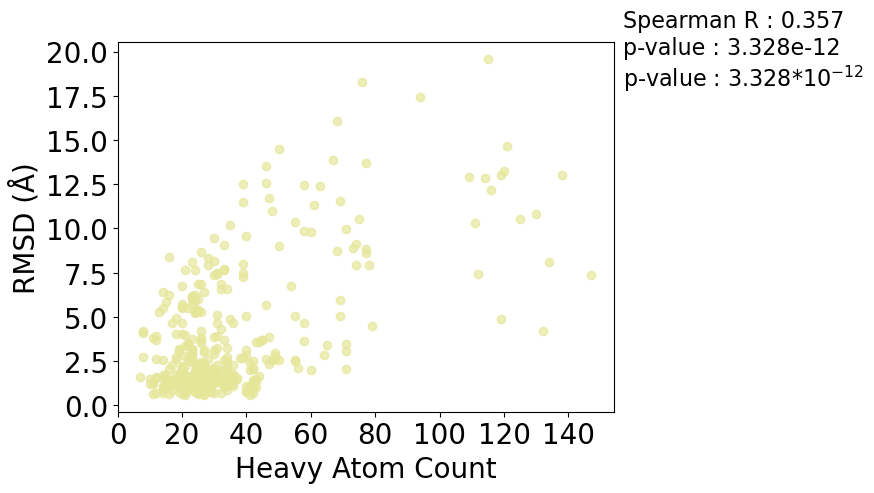

x values plot
0       3
1       1
2       5
3       1
4       8
       ..
354    13
355     2
356     4
357     8
358     4
Name: Rot_Bonds, Length: 359, dtype: int64
y values plot
0      1.823048
1      3.942144
2      6.585749
3      0.679104
4      3.385584
         ...   
354    1.107298
355    5.490958
356    1.255545
357    1.536179
358    2.608791
Name: RMSD, Length: 359, dtype: float64
Spearman R 3 formats
raw 2.0697422308520102e-10
.3e 2.070e-10
sci. not. 2.070*$10^{-10}$


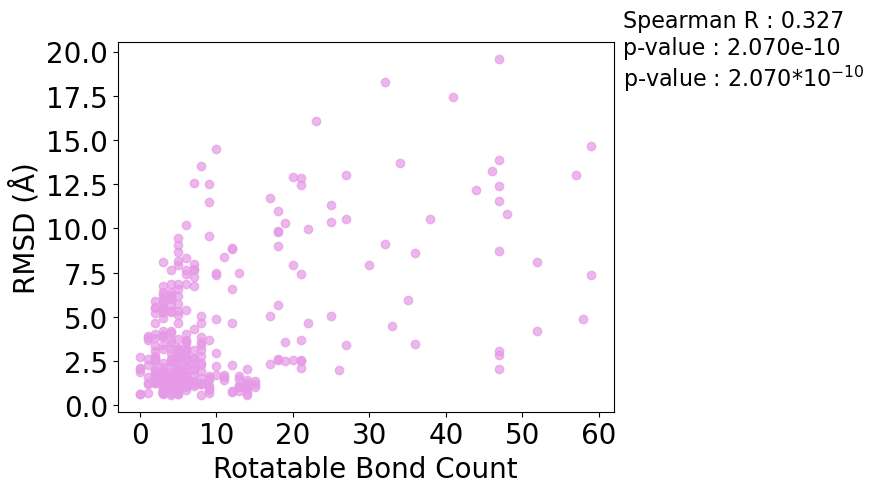

x values plot
0     -11.307296
1     -23.295536
2      -7.285557
3      -1.619504
4     -16.434276
         ...    
354     1.406795
355    -9.706919
356    -3.143189
357   -10.345405
358    -3.690830
Name: Rg_Percent_Error, Length: 359, dtype: float64
y values plot
0      1.823048
1      3.942144
2      6.585749
3      0.679104
4      3.385584
         ...   
354    1.107298
355    5.490958
356    1.255545
357    1.536179
358    2.608791
Name: RMSD, Length: 359, dtype: float64
Spearman R 3 formats
raw 2.7654363004320263e-23
.3e 2.765e-23
sci. not. 2.765*$10^{-23}$


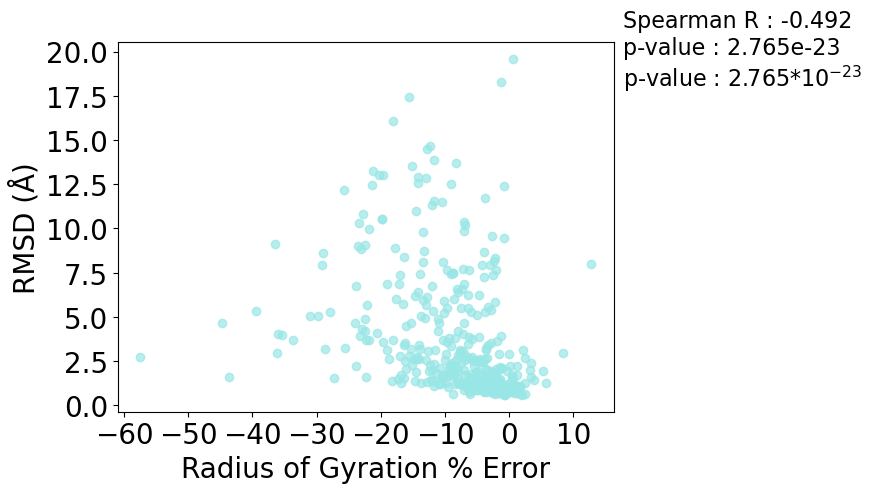

x values plot
0     -11.307296
1     -23.295536
2      -7.285557
3      -1.619504
4     -16.434276
         ...    
354     1.406795
355    -9.706919
356    -3.143189
357   -10.345405
358    -3.690830
Name: Rg_Percent_Error, Length: 359, dtype: float64
y values plot
0      24
1      12
2      32
3      12
4      22
       ..
354    41
355    20
356    23
357    25
358    18
Name: Heavy_Atom_Count, Length: 359, dtype: int64
Spearman R 3 formats
raw 0.2428596135381348
.3e 2.429e-01
sci. not. 2.429*$10^{-1}$


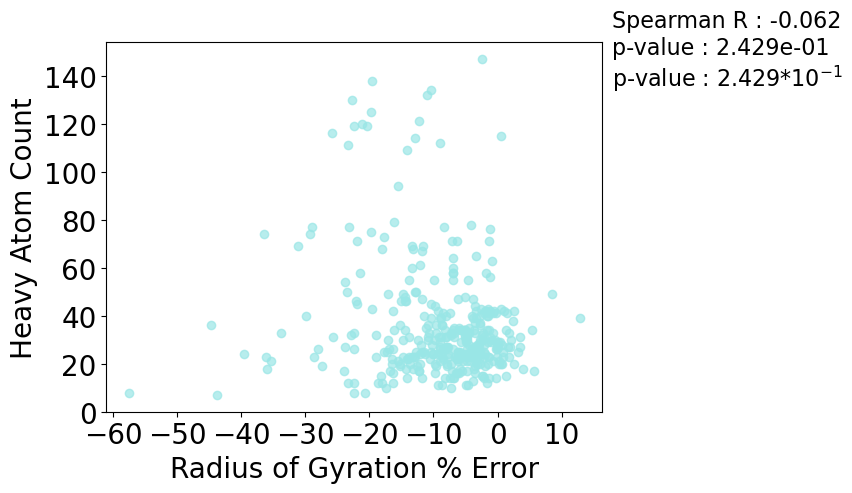

x values plot
0     -22.690913
1     -27.824911
2     -20.940806
3      -7.388140
4     -29.634658
         ...    
354   -14.856041
355   -19.931832
356   -13.074171
357   -24.000908
358   -18.817034
Name: Bond_Distance_Percent_Error_Average, Length: 359, dtype: float64
y1 values plot
0     -11.307296
1     -23.295536
2      -7.285557
3      -1.619504
4     -16.434276
         ...    
354     1.406795
355    -9.706919
356    -3.143189
357   -10.345405
358    -3.690830
Name: Rg_Percent_Error, Length: 359, dtype: float64
y2 values plot
0      1.823048
1      3.942144
2      6.585749
3      0.679104
4      3.385584
         ...   
354    1.107298
355    5.490958
356    1.255545
357    1.536179
358    2.608791
Name: RMSD, Length: 359, dtype: float64


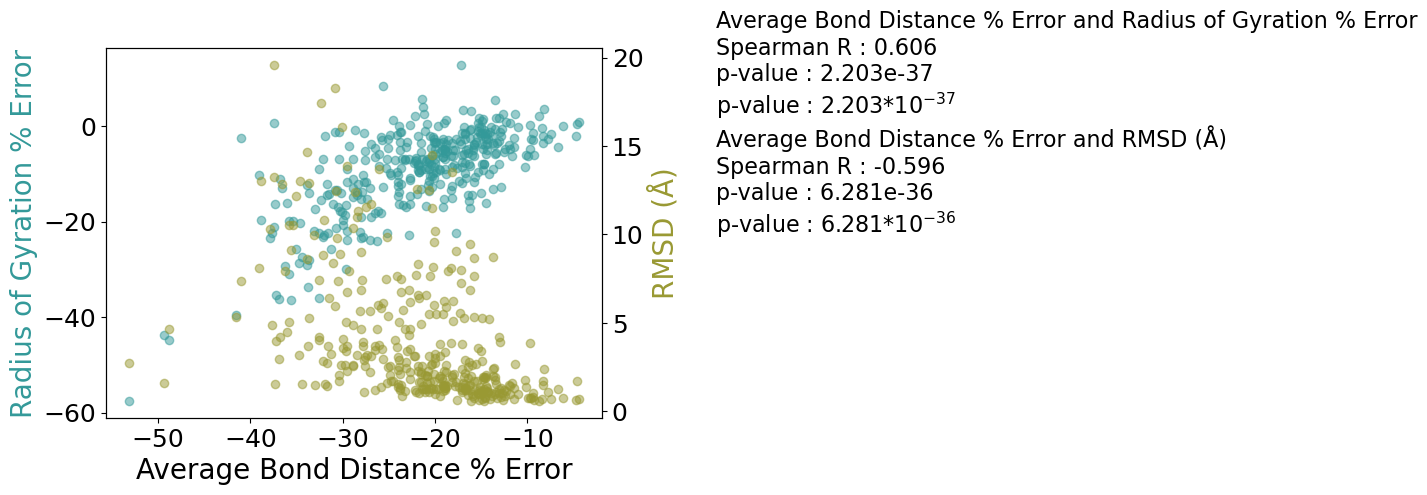

consolidation
len13717
[-28.158155087280107, -5.611971984094593, -7.774512956795277, -9.878611200251013, -0.40044965100064606, -23.378435867887912, -21.58742180049414, -38.360513340150945, -40.234636855783315, -25.28198472337321, -10.729810160683183, -12.897429508691802, -19.83357890835177, -32.0339145193347, -55.86768776224742, -20.18771672785846, -18.26651629817142, -26.80871337154456, -34.27739908788766, -3.172793327349732, -55.13281761919453, -67.52550586226364, -11.002691421786121, -20.88819922487735, -5.571248298334027, -10.185273100691738, -7.606656675333091, -33.63899268669965, -40.133994185019496, -9.376651911416143, -33.16838885323396, -17.016399059864153, -11.196967451502605, -35.2734550672401, -45.447689723040035, -48.2260459679605, -16.30961810664242, -30.84008290939586, -13.270645517808223, -32.55472995313356, -16.237973936184133, -11.09816630939818, -46.474373854890295, -51.80333055414239, -6.609999390901962, -43.927522223312096, -36.738066323115724, -6.289221883871831, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



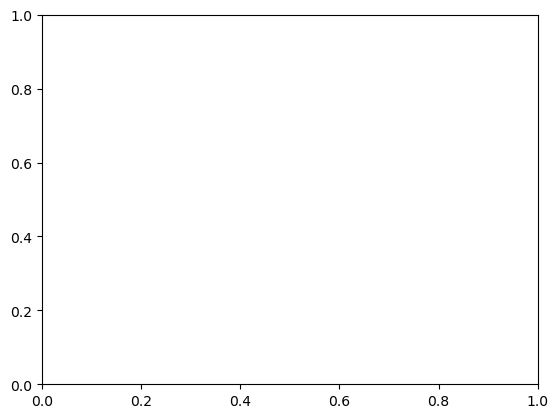

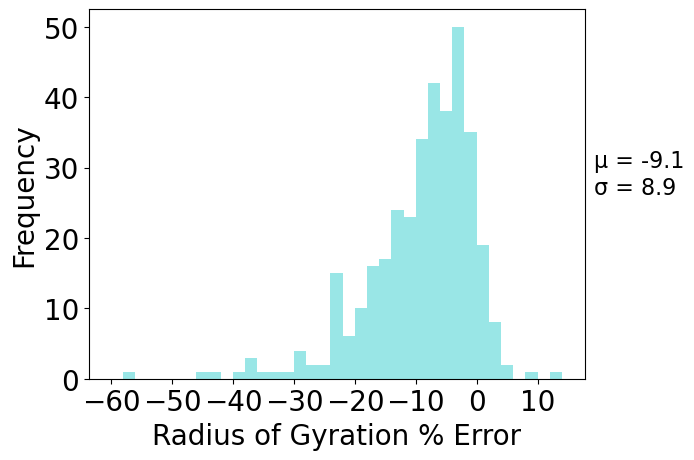

Radius of Gyration % Error has 359 entries, 328 below 0 for 91.36490250696379% below
Bond_Distance_Percent_Error_List
where 0?
(array([], dtype=int64),)


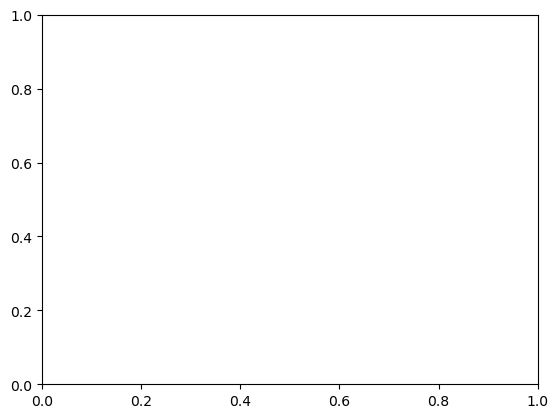

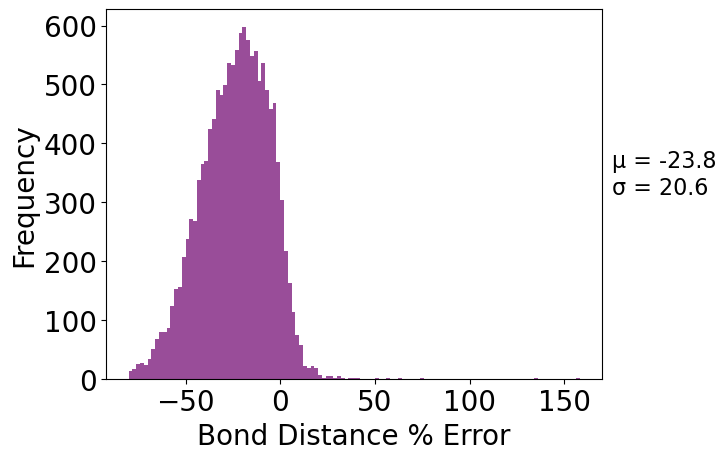

Bond Distance % Error has 13717 entries, 12674 below 0 for 92.39629656630458% below


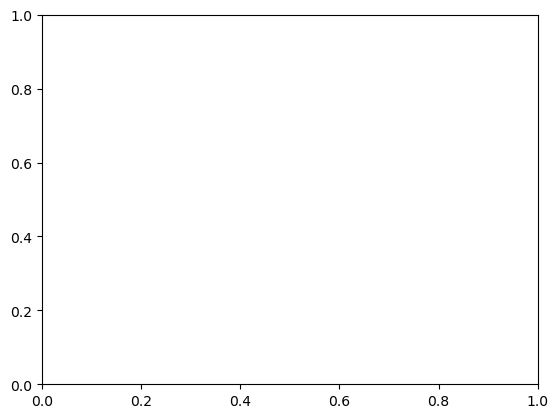

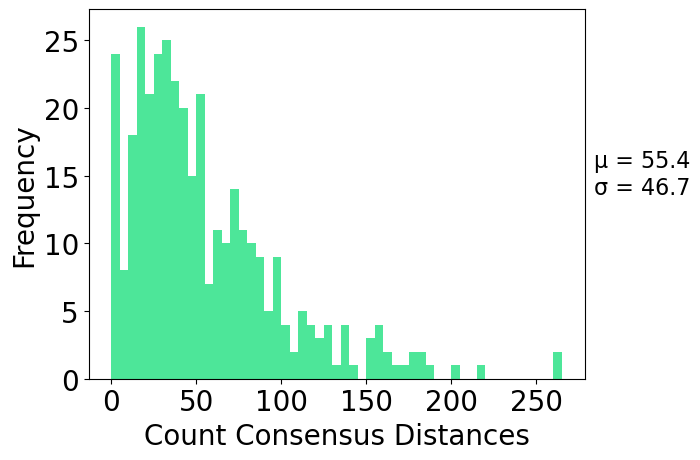

Count Consensus Distances has 359 entries, 0 below 0 for 0.0% below
All_LR_SD
where 0?
(array([], dtype=int64),)


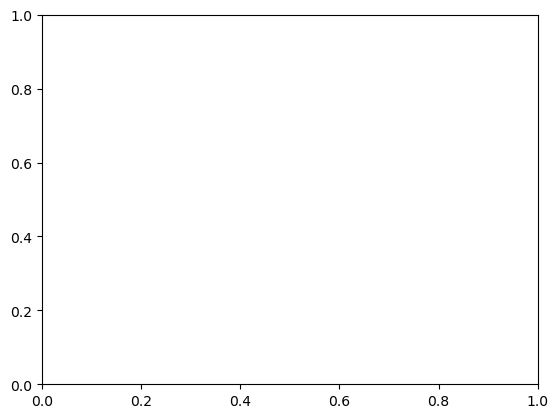

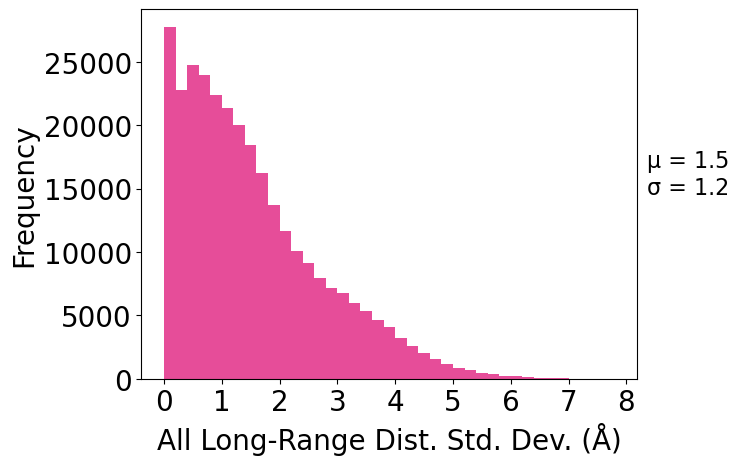

All Long-Range Dist. Std. Dev. (Å) has 297764 entries, 0 below 0 for 0.0% below


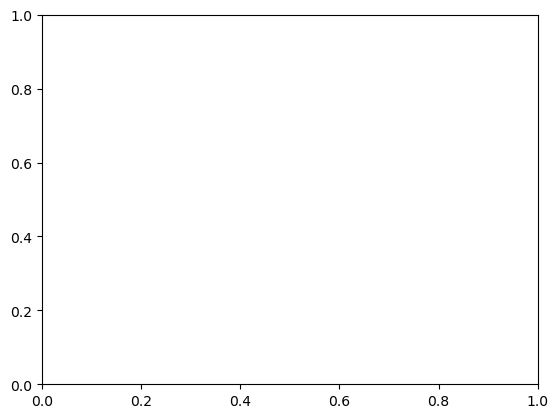

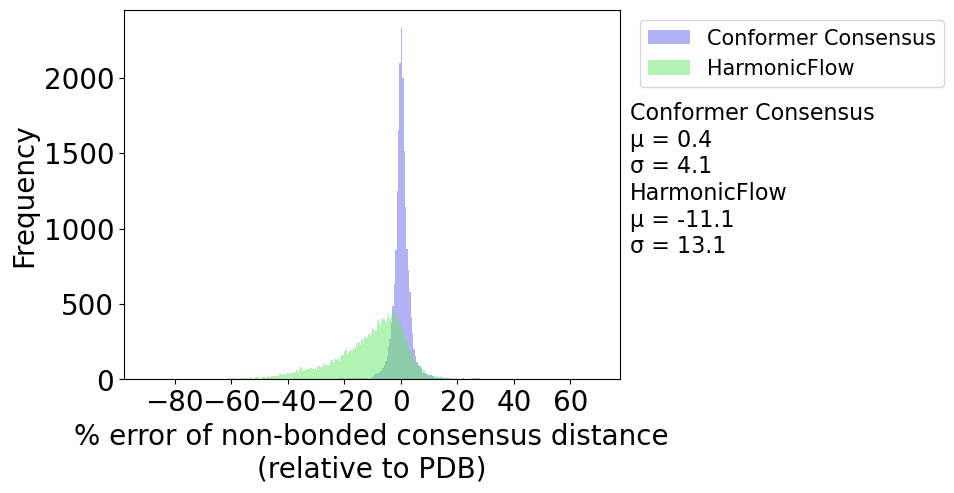

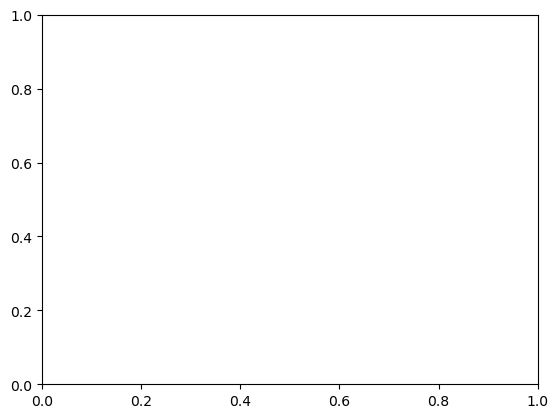

In [92]:
#Create plots- not removing anything
#Check lists match printed df, good
#2/4/24 confirm all plots up to bd % error match stats, good
#this is comparing with Streamline_Analysis_240201_2050
plot_data(pd_df, [])

In [90]:
pd_df["Consensus_Distance_Count"].sum()

19892

In [103]:
print(pd_df[pd_df["Complex_Name"].isin(["6py0", "6nrf", "6qtr", "5zjz"])])
for c_check in ["6py0", "6nrf", "6qtr", "5zjz"]:
    print(c_check)
    print("Conformer_Consensus_Percent_Error")
    print(list(pd_df[pd_df["Complex_Name"] == c_check]["Conformer_Consensus_Percent_Error"]))
    print("Inference_Consensus_Percent_Error")
    print(list(pd_df[pd_df["Complex_Name"] == c_check]["Inference_Consensus_Percent_Error"]))
    print("Consensus_Info_Dict")
    print(dict(pd_df[pd_df["Complex_Name"] == c_check]["Consensus_Info_Dict"]))
    #print("All_LR_SD")
    #print(list(pd_df[pd_df["Complex_Name"] == c_check]["All_LR_SD"]))

    Complex_Name       RMSD  Heavy_Atom_Count  Rot_Bonds    Rg_PDB    Rg_Inf  \
27          6nrf   1.537123                37          4  5.896089  5.736530   
111         6qtr  17.456148                94         41  9.868375  8.336462   
140         6py0   2.239049                21          5  4.585075  4.338154   
185         5zjz  10.834356               130         48  8.394708  6.487174   

     Rg_Percent_Error                   Bond_Distance_Percent_Error_List  \
27          -2.706182  [-19.6876323830356, -41.46534999107442, -39.47...   
111        -15.523455  [-27.663506000900334, -19.412624457180726, -35...   
140         -5.385337  [-14.793005113237022, -15.00823463506898, -31....   
185        -22.723056  [-65.98928373069722, -47.47102092698888, -33.0...   

                      Bond_Distance_Percent_Error_Dict  \
27   {(0, 18): {'inf': 1.083535878501491, 'pdb': 1....   
111  {(0, 1): {'inf': 1.0548895676799528, 'pdb': 1....   
140  {(0, 1): {'inf': 1.3021820149272516, 'p

In [ ]:
#consensus distance counts- compare with Gen_Conformer_Test_240201_2130
#6py0 has 4, 6nrf has 77, 6qtr has 42, 5zjz has 64 good

#consensus pct errors and inf
#6py0 match  good
#consensus distance pe list- relative to conformers
#[3.51940603026987, 2.8253217493780265, 7.927803111924723, 14.412831402255808]
#consensus distance pe list- relative to inference
#[-2.2602189409821625, -14.382359350074113, 5.060666668057455, 11.875740515355558]

#6nrf match good
#consensus distance pe list- relative to conformers
#[1.9010143855905843, 0.14300409240068349, 0.2495840993683197, -2.751217623018728, -1.7272383796153055, -1.0259911192770443, -0.23148755995362102, -2.7365861171643426, -3.428217525975963, -1.5611083838767883, -0.5144526911693704, 0.4224709714630746, 0.6147357184584455, 0.9316520735418887, 0.11800518266656256, 0.8418546578453824, 2.004391948249912, 1.662490561792671, 2.2742185554446346, -1.4838090217029642, -0.8427479017224279, -0.3947755322809376, -0.14563482818799212, 0.15719379328456187, 0.40550145341271837, 3.403685506587259, -0.6535405785269923, -0.38092543764994385, -0.3671534131019658, -0.16045759768352813, -0.22410056283736163, -0.6183483443744985, -0.6536492483598024, -0.4191570860405378, 1.231791997947726, -0.8000570929816256, -1.3676886141776818, -0.6421133216192504, -1.217017999957538, -0.7851876486131874, -1.5999409635216575, -2.3676676108141645, -5.215213317252442, 0.9860097518120617, -1.3147632484835678, -1.3255081133183384, 1.3676782667480183, -0.6904838259680336, -0.8015219552564081, -1.360381638477304, -1.133941225654004, -0.6262384710859953, -0.14420957441335208, -0.759453349141383, 1.1606766236804726, -0.6898359751442152, 0.793750987236015, 0.6177035315749156, 1.25395547630265, 0.6796489647878622, -0.9063739809069861, -0.8546450268382187, -2.1125531049252193, -2.1120662728914295, -1.3486858260899113, 1.2008581332803638, 0.049727561489157364, -0.8195550531077741, -0.44624588778039825, -1.4805028489345622, -0.1895886713201796, 0.8644812805106391, 2.3339986801082517, 1.1502409488760923, 1.055826696778391, -1.0090354957290386, -2.1967626384474244]
#consensus distance pe list- relative to inference
#[-17.58571850784899, -7.9159349105652375, -7.112135690400866, -19.055522779634817, -10.415406483633149, -6.063339668765588, -10.350244921425201, -8.418016698418816, -37.25553418307519, -17.96896279066257, -9.810668846064427, -1.4949404028200668, 3.5888475912017697, 9.732331537100372, -6.16189114176679, -9.182527956086929, -15.573699937103628, -6.411193080834761, -6.194326961149237, -1.0350208227057374, -4.413901830226865, -2.9513623002313154, -2.933551792879997, -3.4788974679128932, -1.907634810406706, -3.810647861596459, -16.34835296041301, -15.207286015922914, -10.45514885295109, -13.483714557932052, -9.240740909810722, -11.540456197745224, -11.600106146480975, -9.917482116405154, -10.966896009893846, -17.537554744451754, -11.655783906280497, -8.274636773202852, -11.949244540520572, -9.441060929526158, -34.61771240256642, -38.723325101344045, -44.33264674804663, -27.320196650167112, -38.9612350986166, -23.052542245837746, -2.935013342372967, -27.629429935492272, -19.053219751272852, -22.78686110313254, -27.120974560495917, -17.177693956130376, -8.73729011305666, -14.016342991625622, -29.315986025392537, -9.251676876461033, -3.3937832717112886, 1.0790167747597894, 3.4077695755393225, 0.7008983000428046, -6.098823626410947, -16.914220451287115, -8.324556033044889, -8.901007125775608, -11.478419023308762, -20.658051971499816, -7.917233752003187, -32.73664754193038, -31.448259912446893, -10.085852621346891, -5.712494294697797, -4.8617424935535825, -6.253685916961075, -10.133622988506344, -28.37260704245759, -11.345578328371792, -2.512141088195539]

#6qtr match good
#consensus distance pe list- relative to conformers
#[2.1004344379828606, 3.810949323659038, 0.4737233610857225, 1.9742099066170897, 1.2910458804872011, 3.960144024160654, 27.895342939019518, -19.378967891417552, 1.3404924163760323, 2.886584256768848, 26.595727124418673, -20.92689793935693, 7.173370731890907, 1.5260968857071349, 0.07800626948980784, 1.379617178024961, 2.69242403325498, 1.217979901220705, 1.1558495429669997, 0.8232114700980189, 0.6420777836166481, 0.8653978298824837, 0.7246240744339947, 0.7737083636006823, 0.8912805213683493, 0.9298610142535715, 0.40279800259803245, 1.7860350456277267, 1.0423585187539472, 1.2565342188223365, 0.45758300561535714, 0.20138746692846865, 0.31695172146331846, 0.3177765975739739, 0.2112082800364197, -0.028567907819224334, 0.3134055386708859, -0.046097656890445975, 1.072143454326248, 0.0636909949923208, 0.9627399268669264, 0.27581103234730825]
#consensus distance pe list- relative to inference
#[-7.275826116748243, -5.703092570145563, -3.5326548498013333, -24.128600768414046, -10.473941728306505, -29.563979922331793, -13.525324600069883, -50.794064400344624, -14.405363734593257, -20.739174659926526, -35.84190201229298, -37.8153298971022, -13.645271397213866, -8.138948426487639, -25.248407359206105, -19.837665800886388, -33.947103790650715, -32.32465803015197, -23.067521627416625, -31.084142758517284, -37.19585435290956, -26.495150545297935, -29.633746059834493, -33.340624852342785, -34.35314909706843, -53.186183550720976, -26.22051460678698, -31.439553816429704, -19.650032407686584, -24.014742756664933, -27.9581667187905, -28.286898610110853, -32.55467125356307, -27.614187901721678, -25.08523420562228, -26.992410175153296, -19.76629354183534, -23.978662195141034, -34.988060162063704, -25.251277935731828, -41.749814596026134, -29.173969170717502]

#5zjz match good
#how many consensus distances? 64
#consensus distance pe list- relative to conformers
#[-21.013862476685286, 26.898703157178957, -0.04196484384262405, 3.6739363580730036, 0.8838838736838724, 0.41970222500373, 1.5081409622646953, 0.4958238424522645, 0.8287738582966451, -0.027990928702799726, 0.5257416302786297, 0.10874022719858742, 1.7988086036316357, 0.14339346338192416, 0.4402425494465754, 0.1420961415266551, -0.23926360055628929, 0.021806160327594293, -0.4475967227656975, 0.702541518362029, -0.45665569179843046, 0.48519587907462397, -0.09933377082757018, 1.0956006703115766, -0.060469469213072106, 0.7651944873189229, 0.9605582700196181, -20.650277990689204, 28.52795103128406, -6.963208821871123, 8.908776913572291, 3.3967473760889226, 2.173526942653649, 6.208335155907042, -1.0013740986619688, 0.22735959657943763, -1.2727966223902198, -0.5469635769565556, 0.21901930098352926, -0.09200555083733139, 0.12270387293471423, 0.6700120506339922, 0.4767081880972493, 1.8086125186363056, -6.377373250224554, -0.6131888538726897, -0.5164411719339161, 0.45981886421287743, -0.342126325427873, 0.4618101623420516, 0.07684244395428151, -0.349614496289518, 0.4376993280653283, 0.20236935010771087, 0.7947410149526298, 0.2531432318509162, 0.9030712644211024, 0.8421077431084136, 0.2839165247831089, -0.19557107166204601, 0.27418543712950544, 0.6143258355478719, 0.15440446632644192, -0.7293196909775355]
#consensus distance pe list- relative to inference
#[-36.33602380789821, -12.82754744444976, -15.325166923909576, -35.90675603774521, 0.16549932214408702, -13.261045515026332, 33.663009386040954, 13.063545314025797, -33.28314363629198, -41.26136235192126, -27.4651864552136, -31.967940201573523, -9.929342093854906, -38.26211590795465, -38.35312957159185, -36.55036857090542, -39.415558170707584, -24.86123178810595, -31.85389003204931, -55.01947069820203, -36.36601576510179, -61.1263785678478, -48.84030297514698, -28.14255308371576, -34.40284218416582, 28.258344213982493, 12.903119560941594, -20.176262327274245, -7.186304781331557, -38.00594501392774, -46.32407891402858, -16.0196358715567, -14.162434399331236, 6.1425172254509235, 0.6195950908999571, -20.79079576324634, -8.502614554608986, -11.367017891689601, -10.714287935139179, -7.2724748563447505, -3.3951940185536102, -46.90515278335021, -44.860854837817364, -13.462661776670211, -12.97573055197857, -14.809810937058442, -2.962175135204015, 4.8026749929727695, -6.655449249368707, -7.555082837714914, -8.50492437073128, -11.886500416781132, -24.568228029088633, -18.537177894542697, -50.76948813821276, -23.56667578906096, -43.22271469441802, -33.48842507326569, -26.876163447727187, -59.2377175521242, -51.925295567779074, -42.245355186045806, -47.307058825269365, -42.42364615884291]

#compare consensus dictionaries- 1st couple entries
#6py0 match good
#{(0, 3): {'pdb': 2.8828966335961472, 'conformers': 2.984357471565377, 'pdb_conf_pe': 3.51940603026987, 'inf': 2.81773685783467, 'pdb_inf_pe': -2.2602189409821625}, (2, 5): {'pdb': 2.8475861707769257, 'conformers': 2.928039642192167, 'pdb_conf_pe': 2.8253217493780265, 'inf': 2.438036094892773, 'pdb_inf_pe': -14.382359350074113}, (6, 9): {'pdb': 3.3917300894970985, 'conformers': 3.6606197730803367, 'pdb_conf_pe': 7.927803111924723, 'inf': 3.5633742436067535, 'pdb_inf_pe': 5.060666668057455}, (8, 11): {'pdb': 3.215300608030297, 'conformers': 3.6787164637414094, 'pdb_conf_pe': 14.412831402255808, 'inf': 3.5971413650286244, 'pdb_inf_pe': 11.875740515355558}}

#6nrf match good
#6nrf consensus distances dictionary
#{(0, 4): {'pdb': 2.8549497368605277, 'conformers': 2.909222742059627, 'pdb_conf_pe': 1.9010143855905843, 'inf': 2.35288631259566, 'pdb_inf_pe': -17.58571850784899}, (0, 5): {'pdb': 6.532755850328405, 'conformers': 6.54209795854092, 'pdb_conf_pe': 0.14300409240068349, 'inf': 6.015627149350266, 'pdb_inf_pe': -7.9159349105652375}
#(24, 27): {'pdb': 2.779696026546788, 'conformers': 2.751647906965561, 'pdb_conf_pe': -1.0090354957290386, 'inf': 2.4643234365642837, 'pdb_inf_pe': -11.345578328371792}, (32, 34): {'pdb': 3.0819339707398017, 'conformers': 3.0142311967289706, 'pdb_conf_pe': -2.1967626384474244, 'inf': 3.004511441149791, 'pdb_inf_pe': -2.512141088195539}}
 

#6qtr match good
#6qtr consensus distances dictionary
#{(1, 10): {'pdb': 3.7865072296246858, 'conformers': 3.8660403314724334, 'pdb_conf_pe': 2.1004344379828606, 'inf': 3.5110075476990925, 'pdb_inf_pe': -7.275826116748243}, (3, 10): {'pdb': 2.7540588229012126, 'conformers': 2.8590146089857384, 'pdb_conf_pe': 3.810949323659038, 'inf': 2.5969922987948952, 'pdb_inf_pe': -5.703092570145563}
#(88, 89): {'pdb': 2.7638959821237816, 'conformers': 2.790505112280758, 'pdb_conf_pe': 0.9627399268669264, 'inf': 1.609974533960087, 'pdb_inf_pe': -41.749814596026134}, (88, 92): {'pdb': 3.640366053022686, 'conformers': 3.650406584214749, 'pdb_conf_pe': 0.27581103234730825, 'inf': 2.578326783012582, 'pdb_inf_pe': -29.173969170717502}}

#5zjz match good
#{(1, 4): {'pdb': 3.577998602570995, 'conformers': 2.8261228968090046, 'pdb_conf_pe': -21.013862476685286, 'inf': 2.277896178494533, 'pdb_inf_pe': -36.33602380789821}, (2, 4): {'pdb': 2.996462414247838, 'conformers': 3.802471944272802, 'pdb_conf_pe': 26.898703157178957, 'inf': 2.612089776405092, 'pdb_inf_pe': -12.82754744444976},
#end (124, 127): {'pdb': 2.7621185709523766, 'conformers': 2.766383405391159, 'pdb_conf_pe': 0.15440446632644192, 'inf': 1.4554415137682462, 'pdb_inf_pe': -47.307058825269365}, (125, 126): {'pdb': 2.84674586150573, 'conformers': 2.825983983385681, 'pdb_conf_pe': -0.7293196909775355, 'inf': 1.6390524701790352, 'pdb_inf_pe': -42.42364615884291}}

#LR SD lists
#6py0
#all pair sd list match
#[0.07199367117749465, 0.17702076411884635....1.0487080521766985, 0.6879352118856541]
#6nrf
#all pair sd list match
#[0.12080109229704707, 0.5930793281189362,...0.39101373616056967, 0.3854277672672214]
#6qtr
#all pair sd list match
#[0.41011121984938037, 0.3353980543288988,...1.1247230645916113, 1.2177365593458067]
#5zjz
#all pair sd list match
#[0.282095228994756, 0.4529594208251584,...1.1514442363404487, 1.125102147315403]

In [ ]:
#Create plots- with removal
#points align with removal, last entries match up- good
remove_list = ['6qsz', '6a6k', '6kqi', '6m7h', '6qtm', '6e4v', '6iql', '6rz6', '6nv9', '6qzh', '5ab1', '4jdf', '1qon', '4pox', '2r23', '4po7', '4nw2', '2w73', '4x6h', '1g6g', '4u6x', '2r23', '4po7', '4nw2', '2w73', '4x6h', '1g6g', '4u6x']
plot_data(pd_df, remove_list)

what is removed?
Empty DataFrame
Columns: [Complex_Name, RMSD, Heavy_Atom_Count, Rot_Bonds, Rg_Percent_Error, Bond_Distance_Percent_Error_List, Bond_Distance_Percent_Error_Average, Consensus_Distance_Count, Conformer_Consensus_Percent_Error, Inference_Consensus_Percent_Error, All_LR_SD]
Index: []
x values plot
0    1
1    2
2    3
3    4
4    5
5    6
6    7
Name: Heavy_Atom_Count, dtype: int64
y values plot
0    1
1    2
2    3
3    4
4    5
5    6
6    7
Name: RMSD, dtype: int64
Spearman R 3 formats
raw 0.0
.3e 0.000e+00
sci. not. 0.000*$10^{0}$


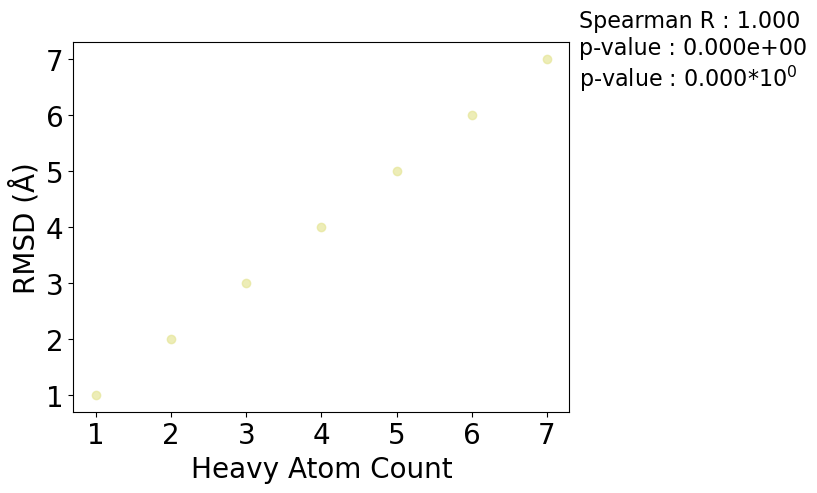

x values plot
0    2
1    2
2    2
3    2
4    2
5    2
6    1
Name: Rot_Bonds, dtype: int64
y values plot
0    1
1    2
2    3
3    4
4    5
5    6
6    7
Name: RMSD, dtype: int64
Spearman R 3 formats
raw 0.14381080871160368
.3e 1.438e-01
sci. not. 1.438*$10^{-1}$


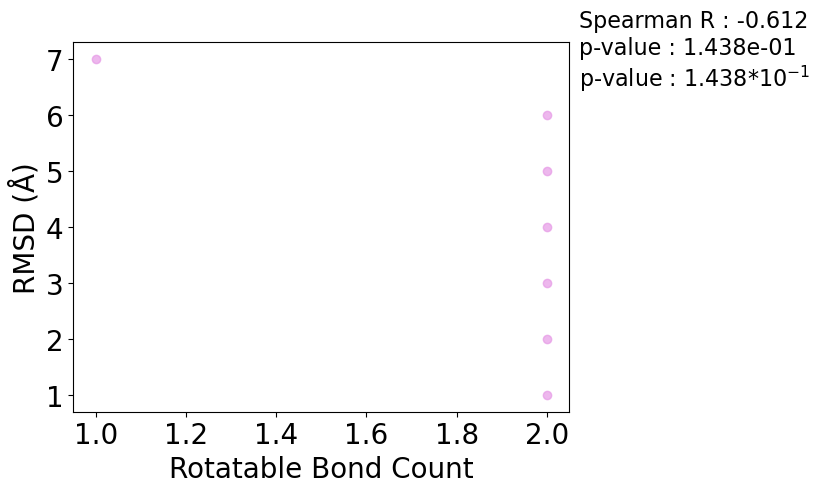

x values plot
0    3
1    2
2    1
3    0
4   -1
5   -2
6   -3
Name: Rg_Percent_Error, dtype: int64
y values plot
0    1
1    2
2    3
3    4
4    5
5    6
6    7
Name: RMSD, dtype: int64
Spearman R 3 formats
raw 0.0
.3e 0.000e+00
sci. not. 0.000*$10^{0}$


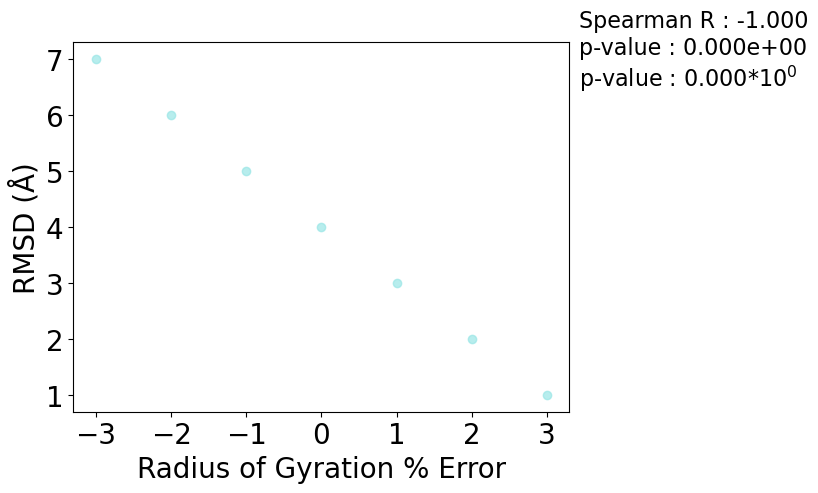

x values plot
0    3
1    2
2    1
3    0
4   -1
5   -2
6   -3
Name: Rg_Percent_Error, dtype: int64
y values plot
0    1
1    2
2    3
3    4
4    5
5    6
6    7
Name: Heavy_Atom_Count, dtype: int64
Spearman R 3 formats
raw 0.0
.3e 0.000e+00
sci. not. 0.000*$10^{0}$


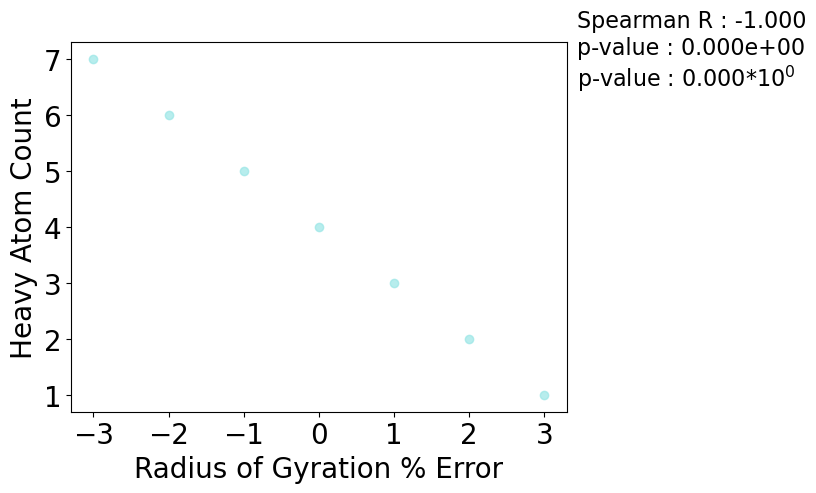

x values plot
0    1
1    5
2   -4
3    2
4   -3
5    0
6   -1
Name: Bond_Distance_Percent_Error_Average, dtype: int64
y1 values plot
0    3
1    2
2    1
3    0
4   -1
5   -2
6   -3
Name: Rg_Percent_Error, dtype: int64
y2 values plot
0    1
1    2
2    3
3    4
4    5
5    6
6    7
Name: RMSD, dtype: int64


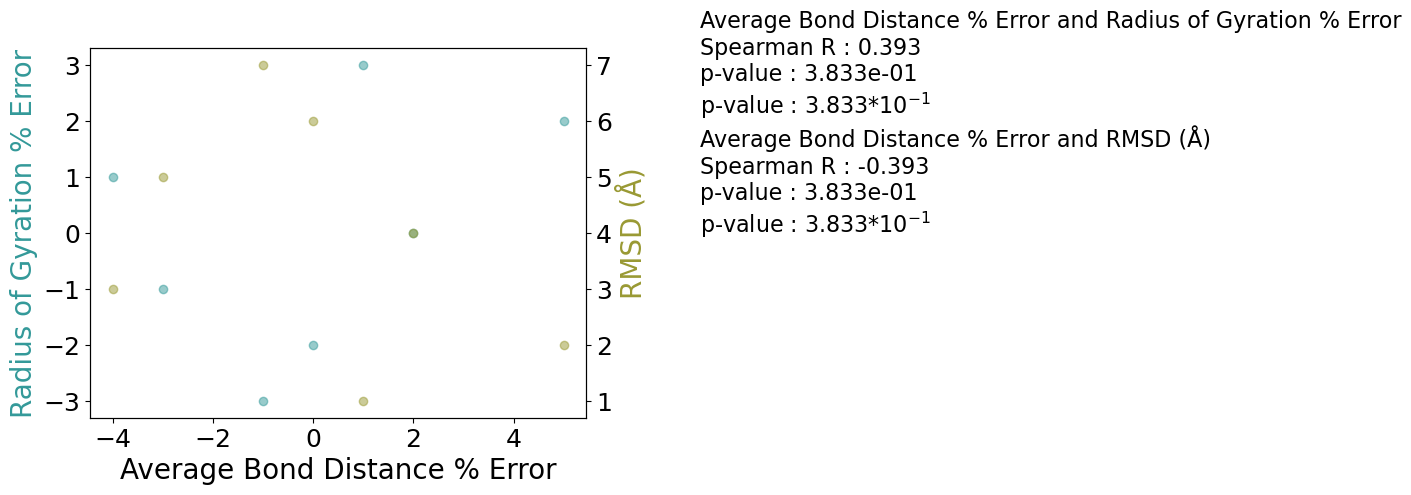

consolidation
len14
[-5, 10, -1, 20, -30, -20, 40, 50, -5, 10, -5, 10, 5, 15]
consolidation
len11
[0.12, 0.15, 0.13, 4.03, 4.04, 3.02, 3.07, 3.42, 3.39, 2.03, 2.95]
consolidation
len12
[-0.5, -0.2, 0.2, 0.6, 0.2, 0.6, -1.5, 1.55, 6.96, 2.03, 10.03, -15.02]
consolidation
len12
[-5.05, -5.1, -4.05, -4.1, -3.05, -3.1, -20.5, -17.2, -23.4, 7.03, 12.02, -30.1]
consensus max 0      2
1      3
2     11
3     21
4     22
5     34
6    101
Name: Consensus_Distance_Count, dtype: int64


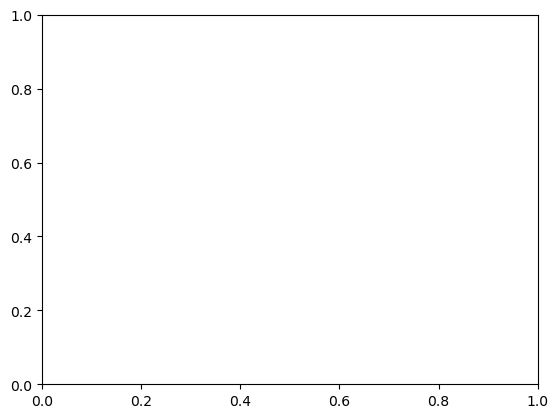

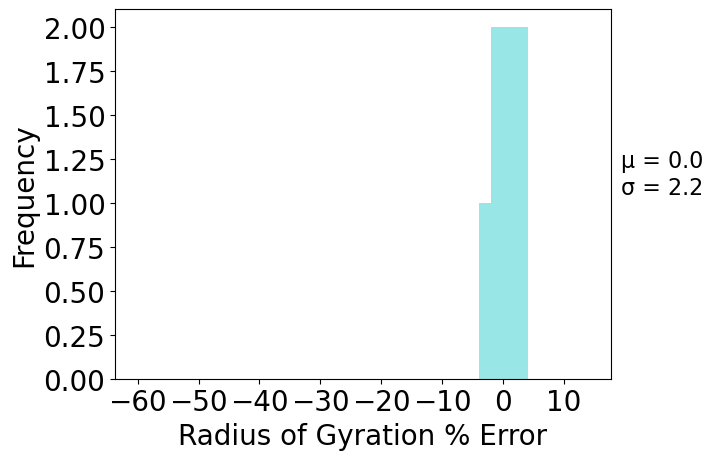

Radius of Gyration % Error has 7 entries, 3 below 0 for 42.857142857142854% below
Bond_Distance_Percent_Error_List
where 0?
(array([], dtype=int64),)


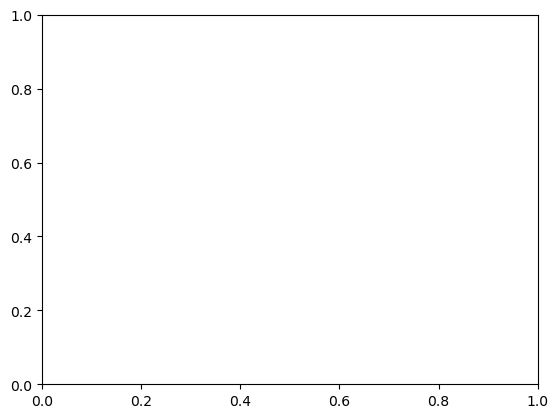

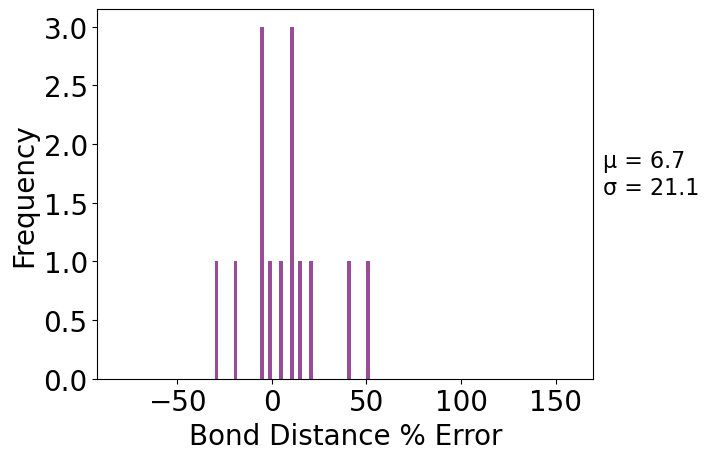

Bond Distance % Error has 14 entries, 6 below 0 for 42.857142857142854% below


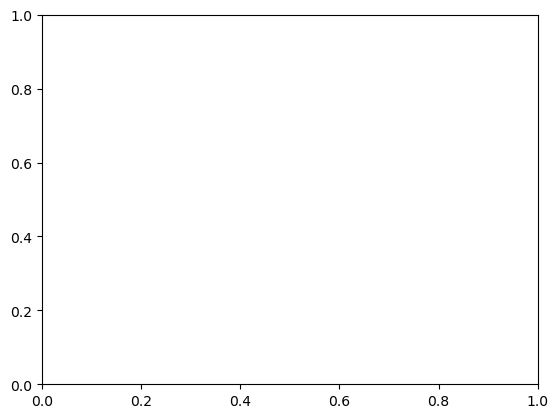

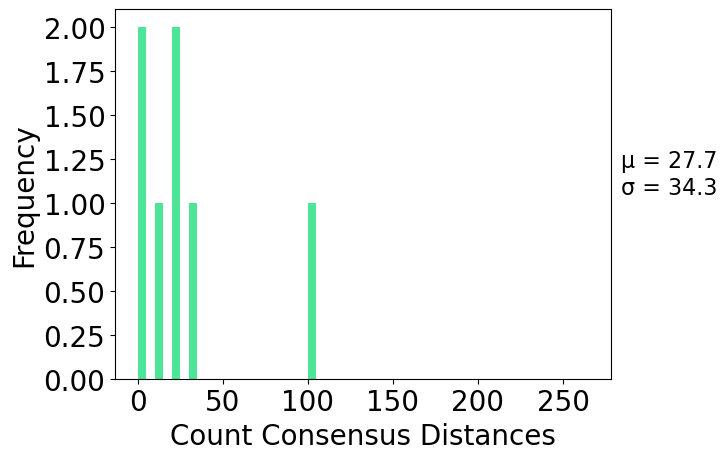

Count Consensus Distances has 7 entries, 0 below 0 for 0.0% below
All_LR_SD
where 0?
(array([], dtype=int64),)


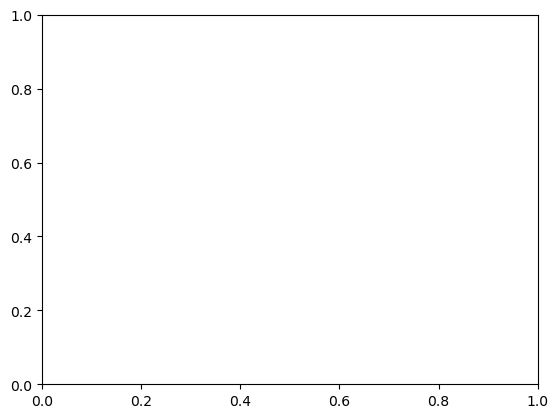

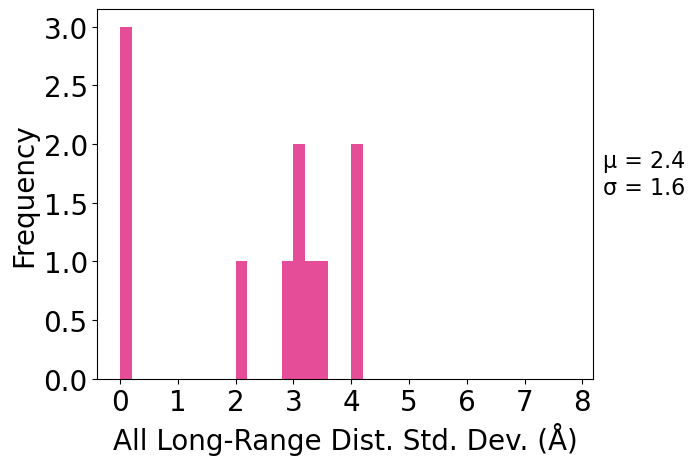

All Long-Range Dist. Std. Dev. (Å) has 11 entries, 0 below 0 for 0.0% below


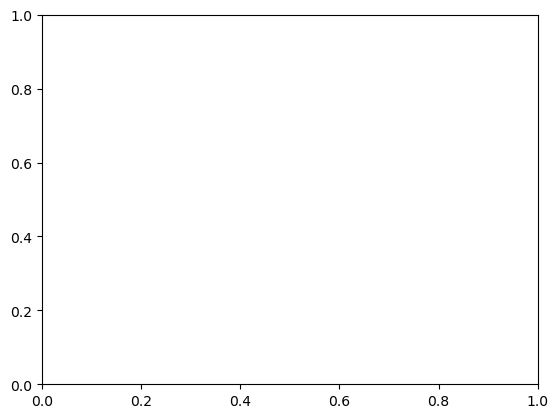

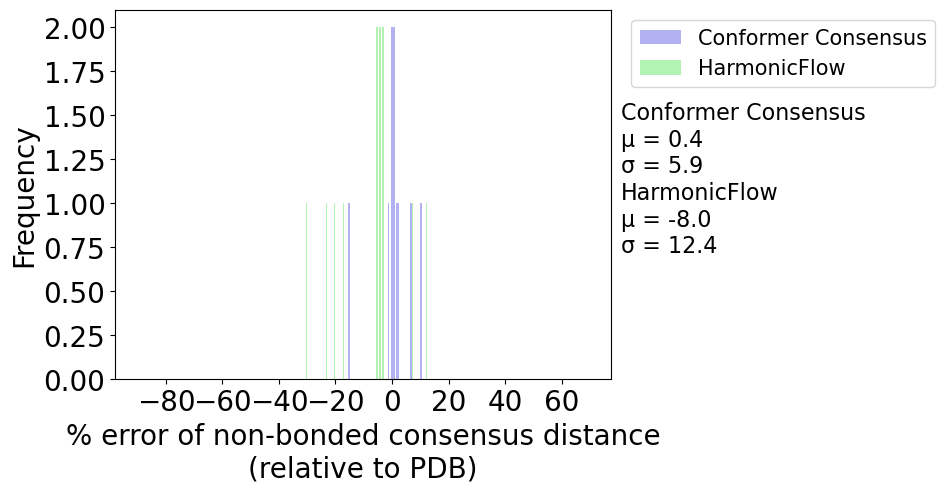

++++++++++++++++++++++++++++++++++++
WITH REMOVALS
what is removed?
  Complex_Name  RMSD  Heavy_Atom_Count  Rot_Bonds  Rg_Percent_Error  \
0            a     1                 1          2                 3   
1            b     2                 2          2                 2   

  Bond_Distance_Percent_Error_List  Bond_Distance_Percent_Error_Average  \
0                         [-5, 10]                                    1   
1                         [-1, 20]                                    5   

   Consensus_Distance_Count Conformer_Consensus_Percent_Error  \
0                         2                      [-0.5, -0.2]   
1                         3              [0.2, 0.6, 0.2, 0.6]   

  Inference_Consensus_Percent_Error     All_LR_SD  
0                     [-5.05, -5.1]  [0.12, 0.15]  
1        [-4.05, -4.1, -3.05, -3.1]        [0.13]  
x values plot
2    3
3    4
4    5
5    6
6    7
Name: Heavy_Atom_Count, dtype: int64
y values plot
2    3
3    4
4    5
5    6
6    7
Name:

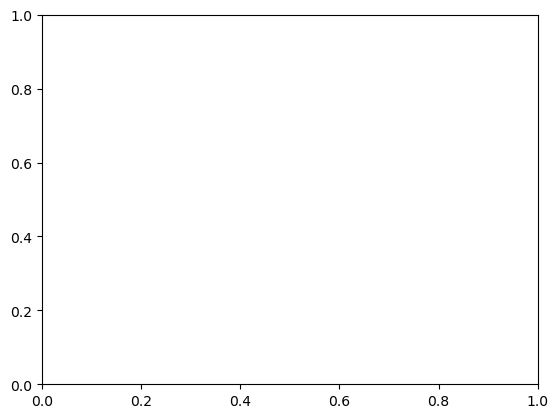

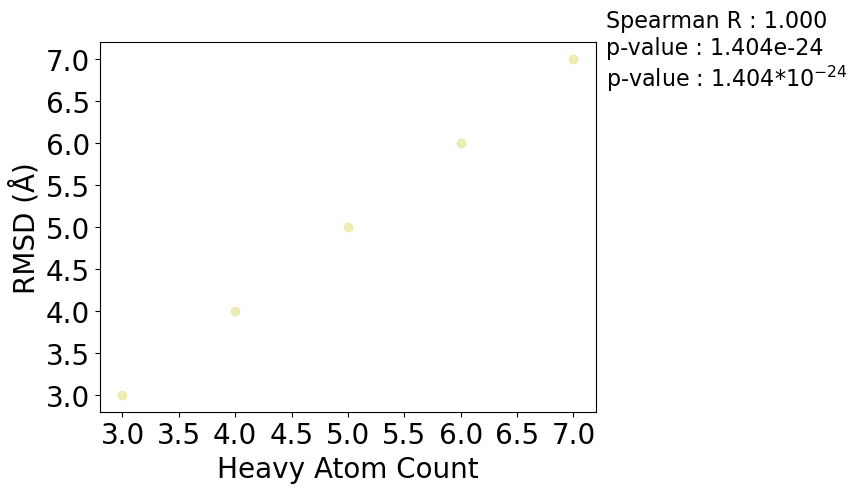

x values plot
2    2
3    2
4    2
5    2
6    1
Name: Rot_Bonds, dtype: int64
y values plot
2    3
3    4
4    5
5    6
6    7
Name: RMSD, dtype: int64
Spearman R 3 formats
raw 0.18169011381620928
.3e 1.817e-01
sci. not. 1.817*$10^{-1}$


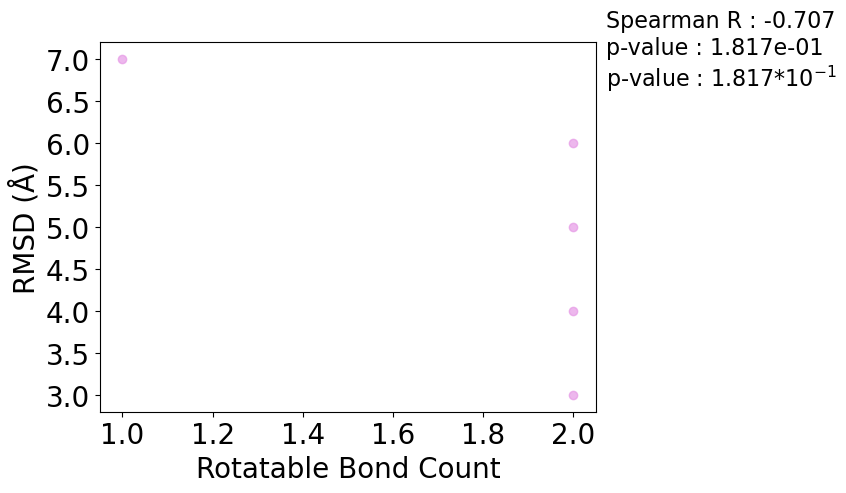

x values plot
2    1
3    0
4   -1
5   -2
6   -3
Name: Rg_Percent_Error, dtype: int64
y values plot
2    3
3    4
4    5
5    6
6    7
Name: RMSD, dtype: int64
Spearman R 3 formats
raw 1.4042654220543672e-24
.3e 1.404e-24
sci. not. 1.404*$10^{-24}$


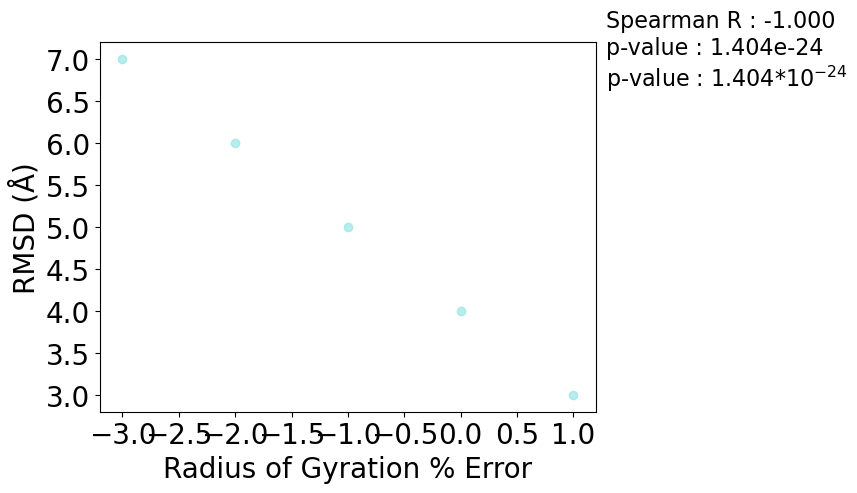

x values plot
2    1
3    0
4   -1
5   -2
6   -3
Name: Rg_Percent_Error, dtype: int64
y values plot
2    3
3    4
4    5
5    6
6    7
Name: Heavy_Atom_Count, dtype: int64
Spearman R 3 formats
raw 1.4042654220543672e-24
.3e 1.404e-24
sci. not. 1.404*$10^{-24}$


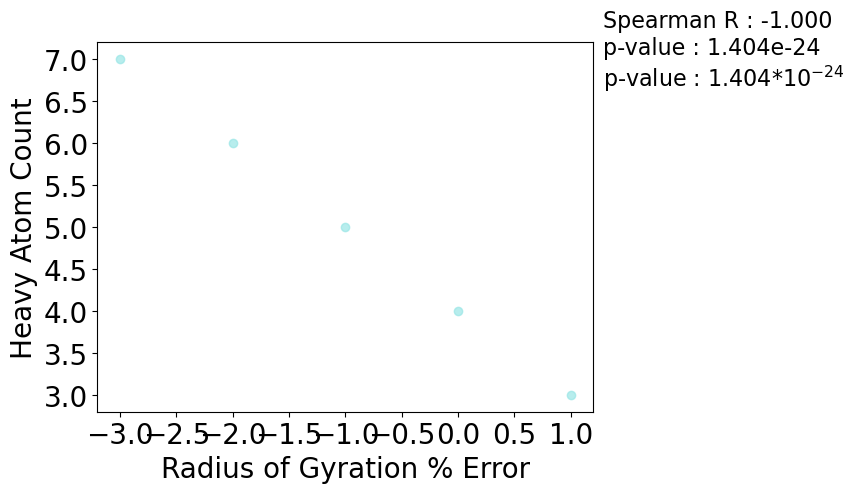

x values plot
2   -4
3    2
4   -3
5    0
6   -1
Name: Bond_Distance_Percent_Error_Average, dtype: int64
y1 values plot
2    1
3    0
4   -1
5   -2
6   -3
Name: Rg_Percent_Error, dtype: int64
y2 values plot
2    3
3    4
4    5
5    6
6    7
Name: RMSD, dtype: int64


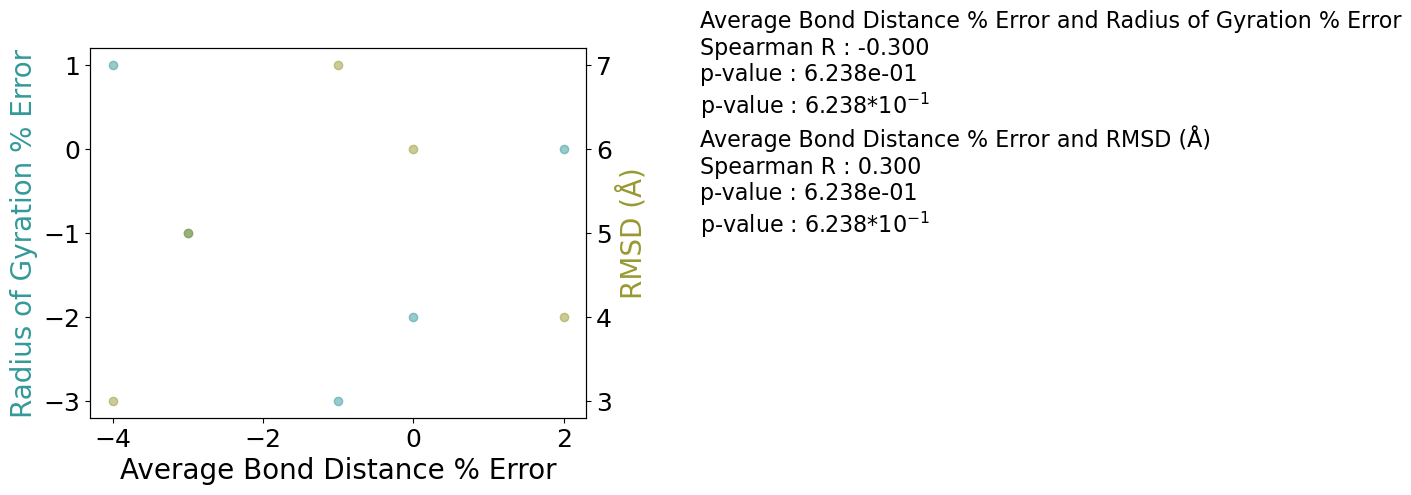

consolidation
len10
[-30, -20, 40, 50, -5, 10, -5, 10, 5, 15]
consolidation
len8
[4.03, 4.04, 3.02, 3.07, 3.42, 3.39, 2.03, 2.95]
consolidation
len6
[-1.5, 1.55, 6.96, 2.03, 10.03, -15.02]
consolidation
len6
[-20.5, -17.2, -23.4, 7.03, 12.02, -30.1]
consensus max 2     11
3     21
4     22
5     34
6    101
Name: Consensus_Distance_Count, dtype: int64


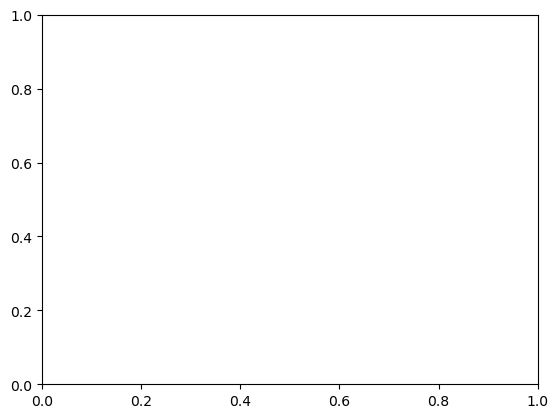

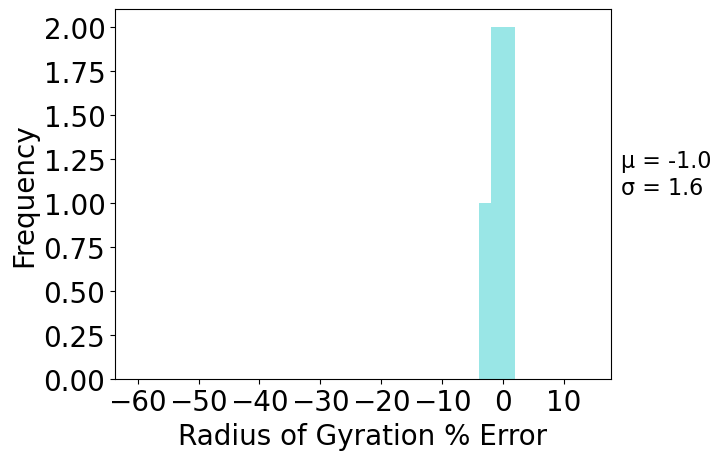

Radius of Gyration % Error has 5 entries, 3 below 0 for 60.0% below
Bond_Distance_Percent_Error_List
where 0?
(array([], dtype=int64),)


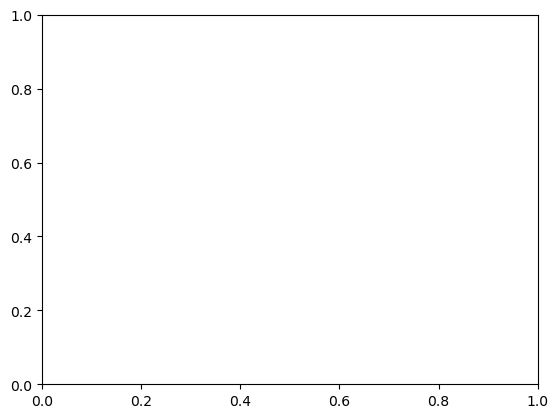

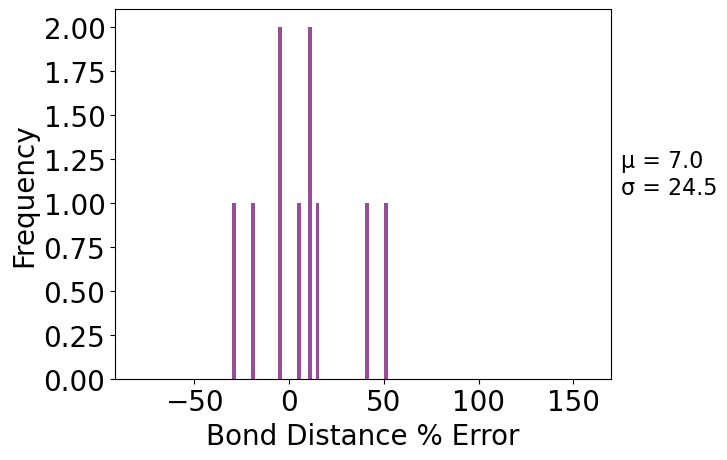

Bond Distance % Error has 10 entries, 4 below 0 for 40.0% below


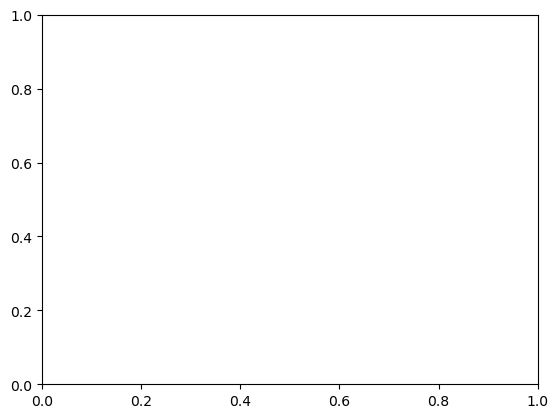

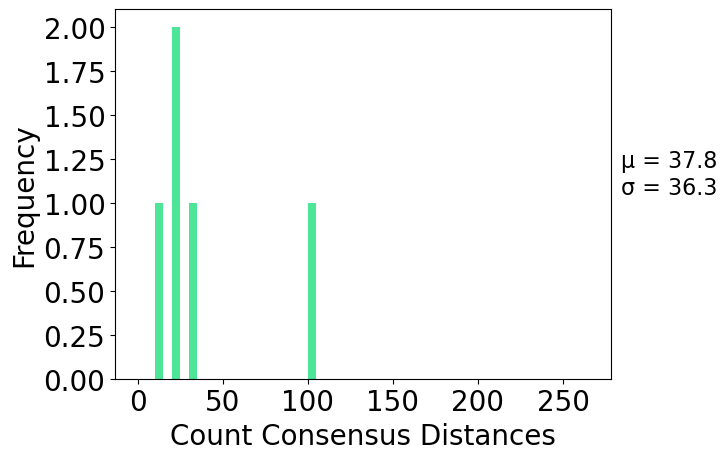

Count Consensus Distances has 5 entries, 0 below 0 for 0.0% below
All_LR_SD
where 0?
(array([], dtype=int64),)


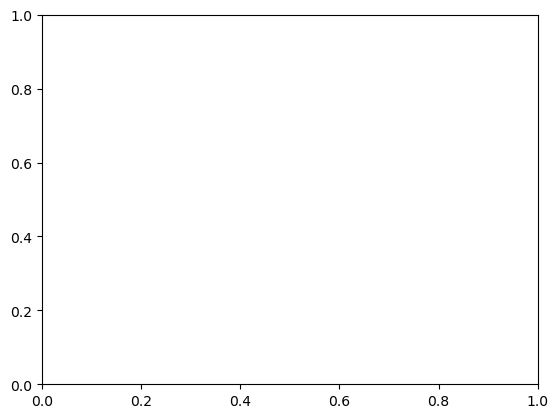

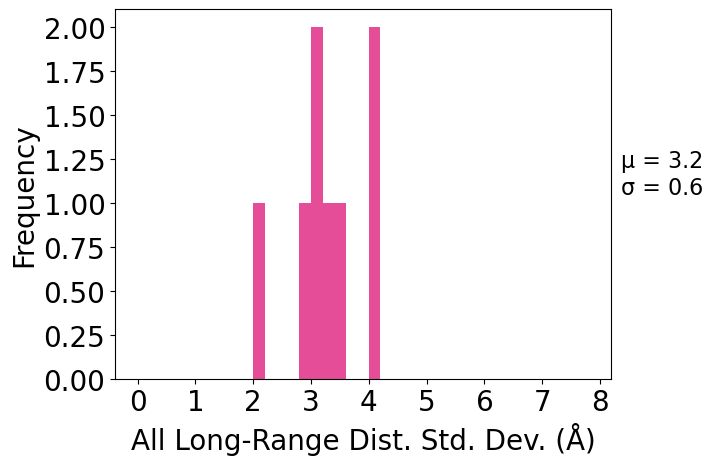

All Long-Range Dist. Std. Dev. (Å) has 8 entries, 0 below 0 for 0.0% below


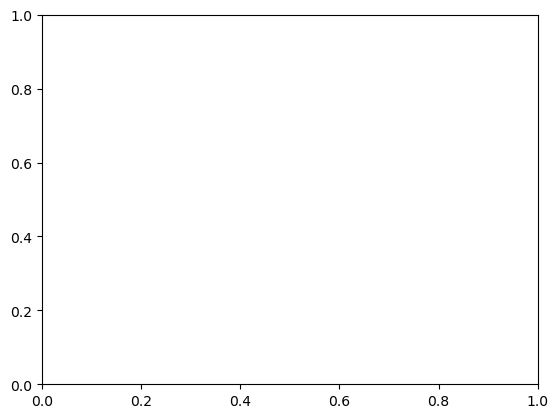

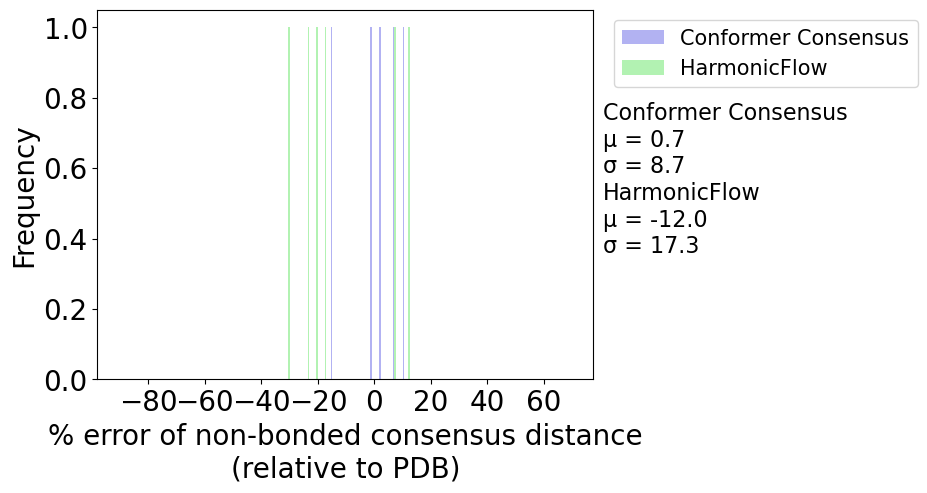

++++++++++++++++++++++++++++++++++++
WITH 3 REMOVALS
what is removed?
  Complex_Name  RMSD  Heavy_Atom_Count  Rot_Bonds  Rg_Percent_Error  \
0            a     1                 1          2                 3   
1            b     2                 2          2                 2   
2            c     3                 3          2                 1   

  Bond_Distance_Percent_Error_List  Bond_Distance_Percent_Error_Average  \
0                         [-5, 10]                                    1   
1                         [-1, 20]                                    5   
2                       [-30, -20]                                   -4   

   Consensus_Distance_Count Conformer_Consensus_Percent_Error  \
0                         2                      [-0.5, -0.2]   
1                         3              [0.2, 0.6, 0.2, 0.6]   
2                        11                            [-1.5]   

  Inference_Consensus_Percent_Error     All_LR_SD  
0                     [-5.05, -

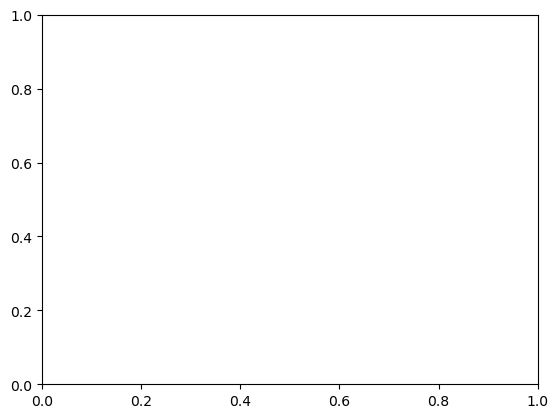

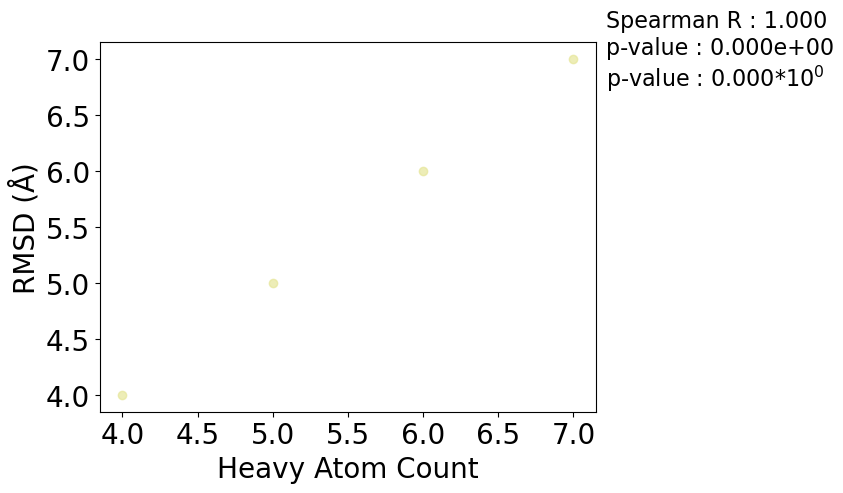

x values plot
3    2
4    2
5    2
6    1
Name: Rot_Bonds, dtype: int64
y values plot
3    4
4    5
5    6
6    7
Name: RMSD, dtype: int64
Spearman R 3 formats
raw 0.22540333075851657
.3e 2.254e-01
sci. not. 2.254*$10^{-1}$


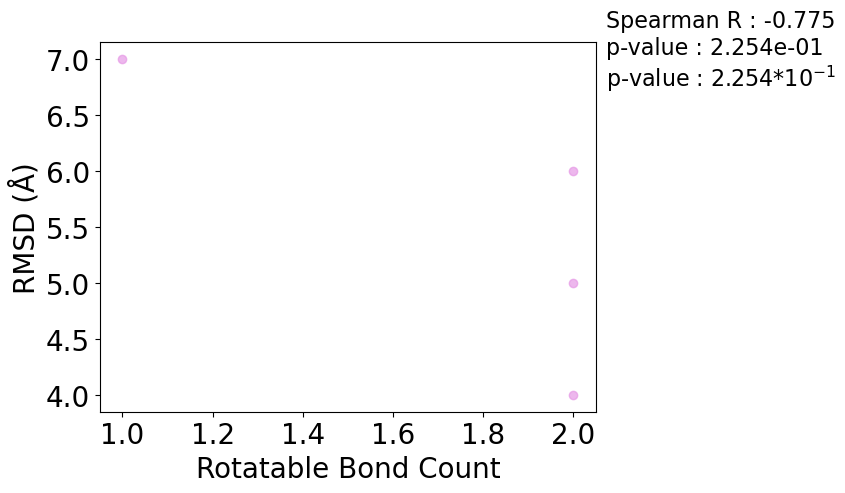

x values plot
3    0
4   -1
5   -2
6   -3
Name: Rg_Percent_Error, dtype: int64
y values plot
3    4
4    5
5    6
6    7
Name: RMSD, dtype: int64
Spearman R 3 formats
raw 0.0
.3e 0.000e+00
sci. not. 0.000*$10^{0}$


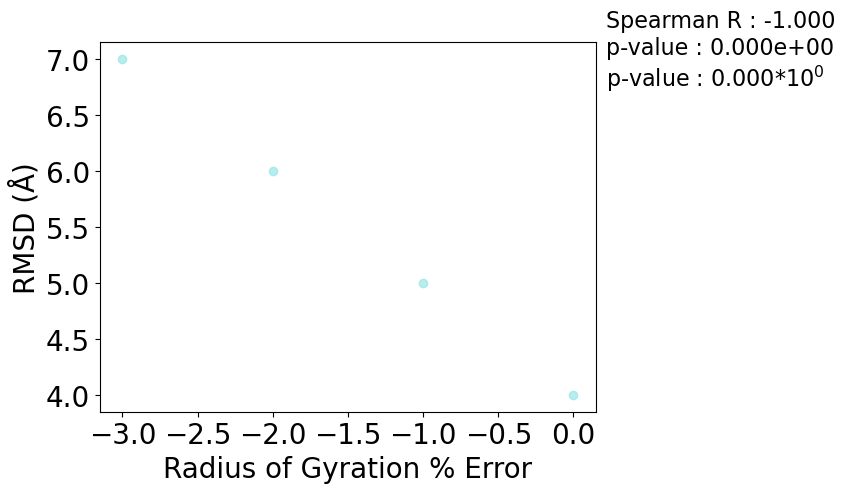

x values plot
3    0
4   -1
5   -2
6   -3
Name: Rg_Percent_Error, dtype: int64
y values plot
3    4
4    5
5    6
6    7
Name: Heavy_Atom_Count, dtype: int64
Spearman R 3 formats
raw 0.0
.3e 0.000e+00
sci. not. 0.000*$10^{0}$


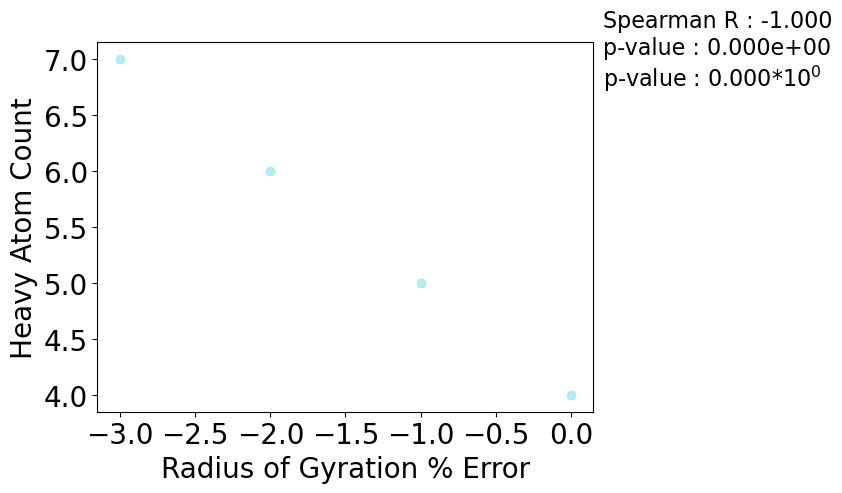

x values plot
3    2
4   -3
5    0
6   -1
Name: Bond_Distance_Percent_Error_Average, dtype: int64
y1 values plot
3    0
4   -1
5   -2
6   -3
Name: Rg_Percent_Error, dtype: int64
y2 values plot
3    4
4    5
5    6
6    7
Name: RMSD, dtype: int64


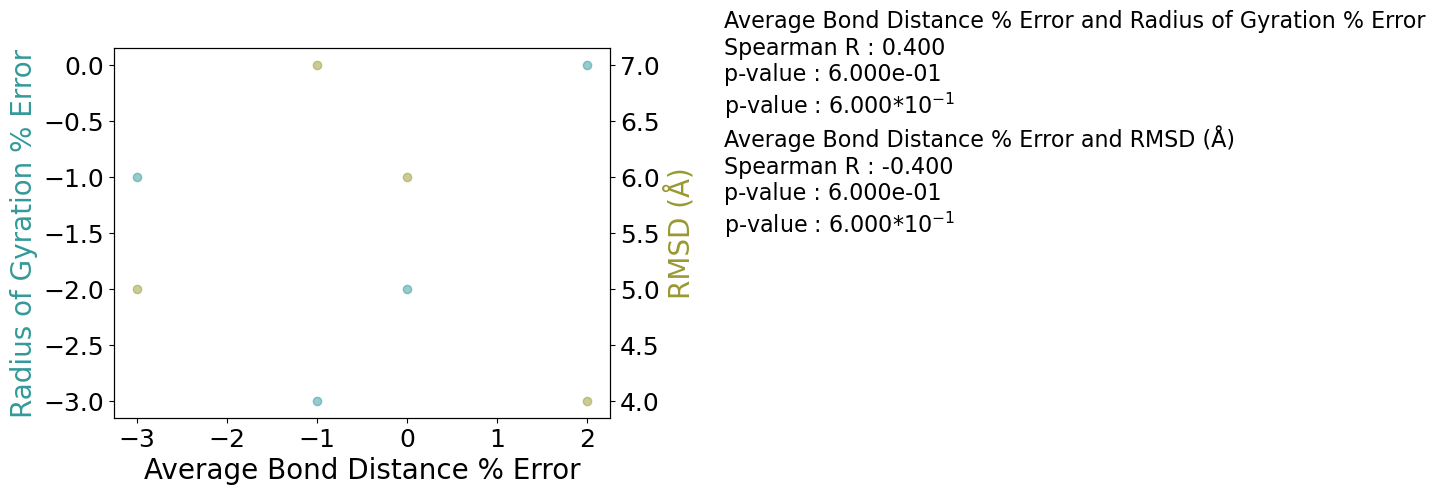

consolidation
len8
[40, 50, -5, 10, -5, 10, 5, 15]
consolidation
len6
[3.02, 3.07, 3.42, 3.39, 2.03, 2.95]
consolidation
len5
[1.55, 6.96, 2.03, 10.03, -15.02]
consolidation
len5
[-17.2, -23.4, 7.03, 12.02, -30.1]
consensus max 3     21
4     22
5     34
6    101
Name: Consensus_Distance_Count, dtype: int64


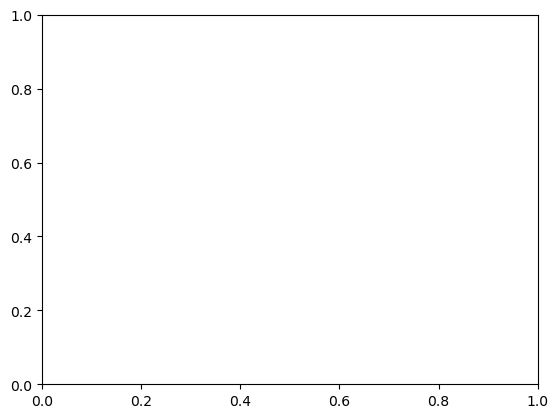

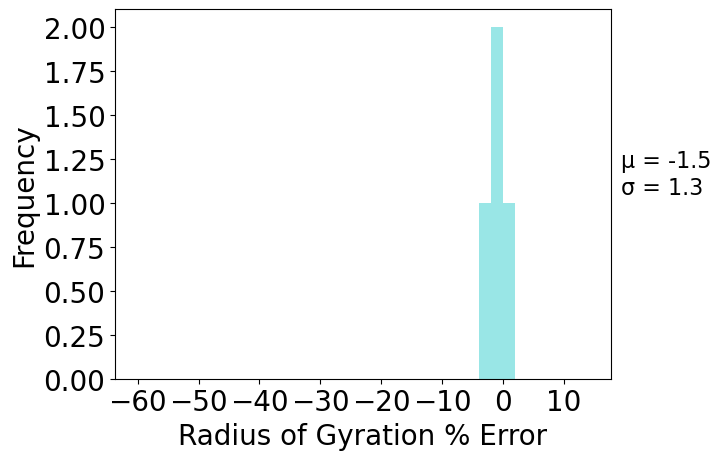

Radius of Gyration % Error has 4 entries, 3 below 0 for 75.0% below
Bond_Distance_Percent_Error_List
where 0?
(array([], dtype=int64),)


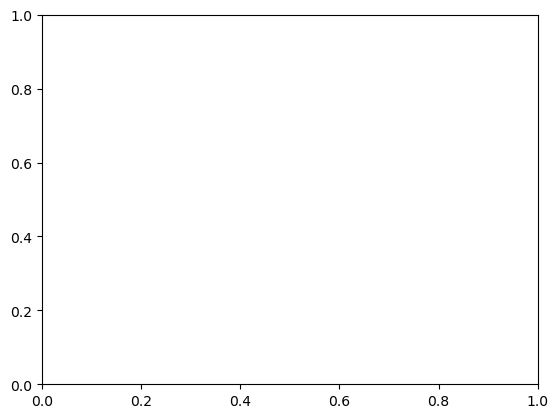

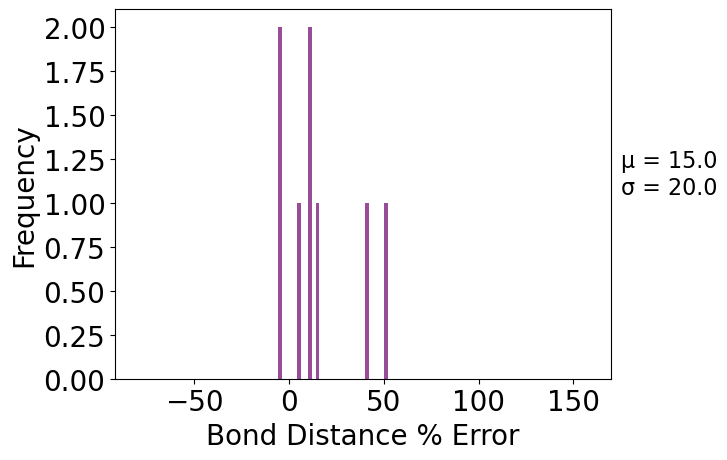

Bond Distance % Error has 8 entries, 2 below 0 for 25.0% below


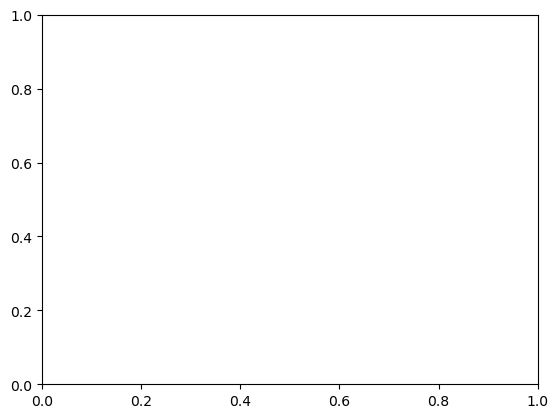

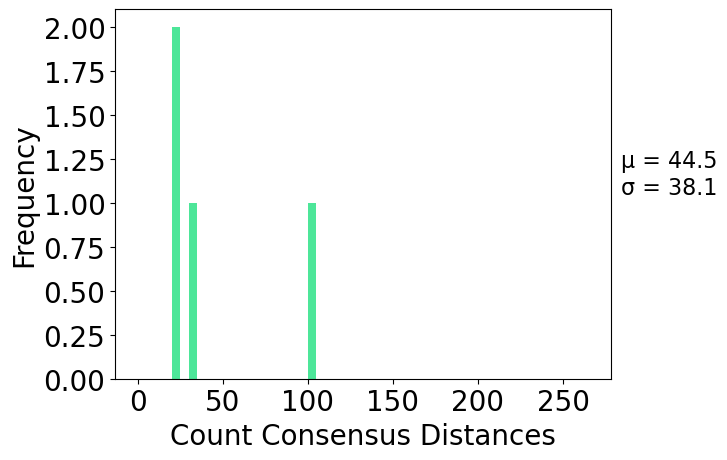

Count Consensus Distances has 4 entries, 0 below 0 for 0.0% below
All_LR_SD
where 0?
(array([], dtype=int64),)


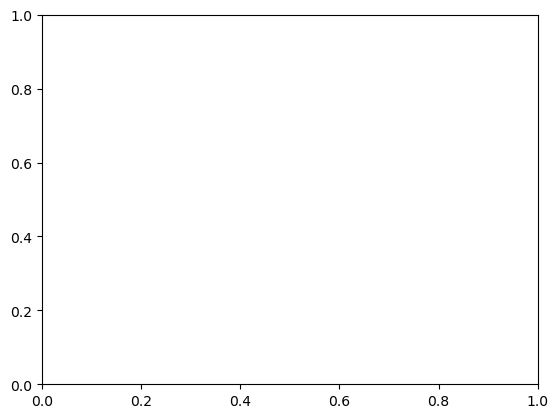

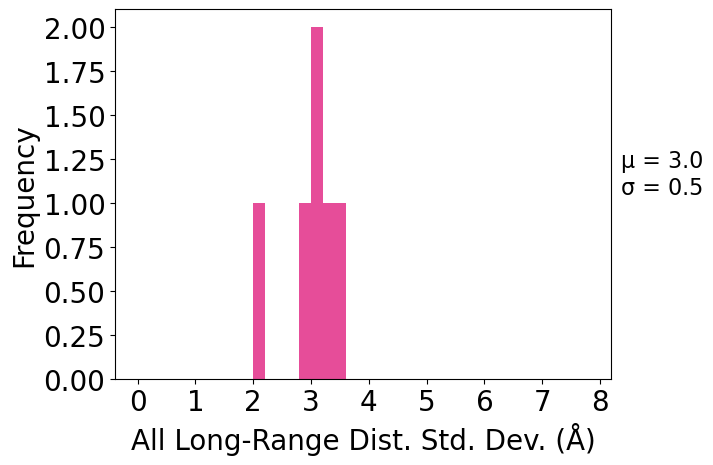

All Long-Range Dist. Std. Dev. (Å) has 6 entries, 0 below 0 for 0.0% below


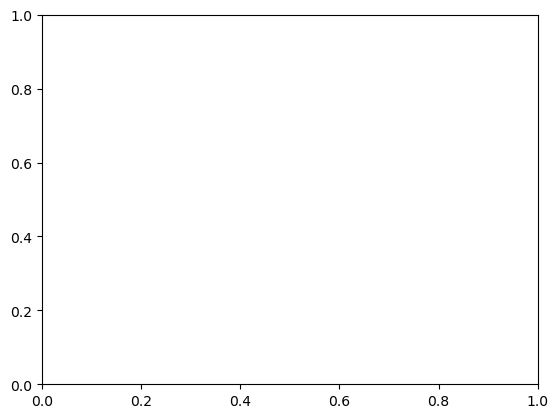

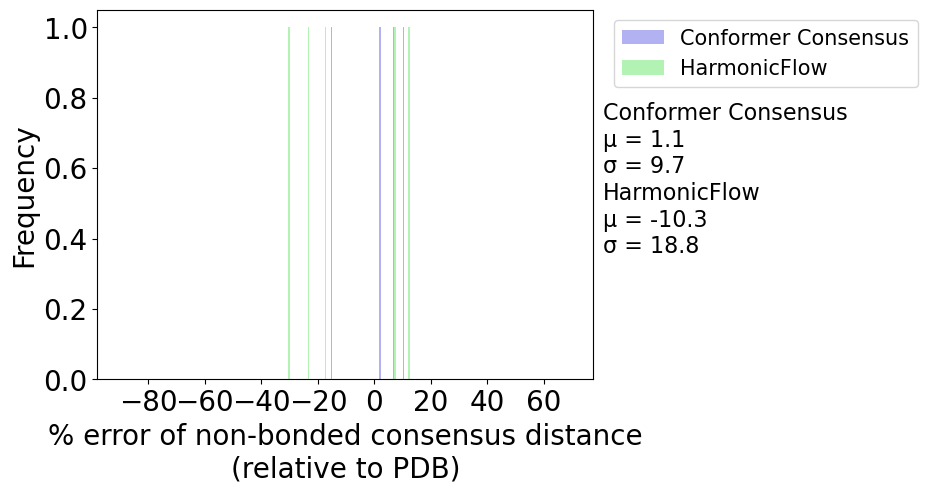

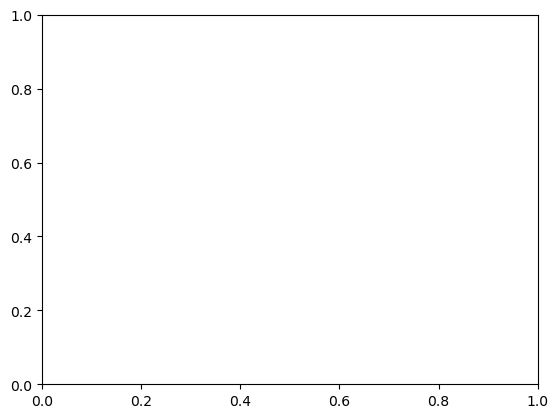

In [108]:
#This is from 2/4 check consensus plots
#Create a sample dataframe to check plotting
#look good, just a bit funny about spearman r pvalue, try in cell below
#Bond_Distance_Percent_Error_List 14 entries good, 6 below 0 good, peaks at -5 and 10 good
#And summary stats match: list consolidation was successful, also confirm with exclusion
#2 y. scatter- RMSD series has (1,1), (5,2), (-4, 3), (2, 4), (-3, 5), (0, 6), and (-1,7) -good
#And Rg pe series has (1,3), (5,2), (-4,1), (2,0), (-3,-1), (0, -2), (-1, -3)
#spearman R matches
#Also with exclusions
#rmsd series (2, 4), (-3, 5), (0, 6), and (-1,7) and rg series (2,0), (-3,-1), (0, -2), (-1, -3)
#consensus avg good, bin pattern of 2 then 1 then 2 then 1 is good
#LR SD 3 in 1st bin then 1 a bit over 2, 1 under 3, then 2 over 3 1 each in next 2 bins and 2 over 4 good
#and sd and avg match good
#conformer consensus see 2 just below 0 2 each just above 0 and right larger 1 bit below, 1 each above/below 2 and near 7, 1 at 10 1 at. -15
#HF see 2 at -5/-4/-3, also -20 and -30 and -17 and -23.4 plus 7 and 12
#consensus avg and sd match, so do hf
#exclusions a b look good, stats good
test_df_dict = {
                "Complex_Name" : ["a", "b", "c", "d", "e", "f", "g"],
                "RMSD" : [1, 2, 3, 4, 5, 6, 7],
                "Heavy_Atom_Count" : [1, 2, 3, 4, 5, 6, 7],
                "Rot_Bonds" : [2, 2, 2, 2, 2, 2, 1],
                "Rg_Percent_Error" : [3, 2, 1, 0, -1, -2, -3],
                "Bond_Distance_Percent_Error_List" : [[-5, 10], [-1, 20], [-30, -20], [40, 50], [-5, 10], [-5, 10], [5, 15]],
                "Bond_Distance_Percent_Error_Average" : [1, 5, -4, 2, -3, 0, -1],
                "Consensus_Distance_Count": [2, 3, 11, 21, 22, 34, 101], 
                "Conformer_Consensus_Percent_Error" : [[-0.5, -0.2], [0.2, 0.6, 0.2, 0.6], [-1.5], [1.55, 6.96], [2.03], [10.03], [-15.02]],
                "Inference_Consensus_Percent_Error" : [[-5.05, -5.10], [-4.05, -4.10, -3.05, -3.10], [-20.5], [-17.2, -23.4], [7.03], [12.02], [-30.1]],
                "All_LR_SD" : [[0.12, 0.15], [0.13], [4.03, 4.04], [3.02, 3.07], [3.42, 3.39], [2.03], [2.95]]
               }
#Ref https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
pd_test_df = pd.DataFrame(data = test_df_dict)
plot_data(pd_test_df, [])
print("++++++++++++++++++++++++++++++++++++\nWITH REMOVALS")
plot_data(pd_test_df, ["a", "b"])
print("++++++++++++++++++++++++++++++++++++\nWITH 3 REMOVALS")
plot_data(pd_test_df, ["a", "b", "c"])

In [ ]:
#Below from 2/1
#Create a sample dataframe to check plotting
#look good, just a bit funny about spearman r pvalue, try in cell below
#Bond_Distance_Percent_Error_List 14 entries good, 6 below 0 good, peaks at -5 and 10 good
#And summary stats match: list consolidation was successful, also confirm with exclusion
#2 y. scatter- RMSD series has (1,1), (5,2), (-4, 3), (2, 4), (-3, 5), (0, 6), and (-1,7) -good
#And Rg pe series has (1,3), (5,2), (-4,1), (2,0), (-3,-1), (0, -2), (-1, -3)
#spearman R matches
#Also with exclusions
#rmsd series (2, 4), (-3, 5), (0, 6), and (-1,7) and rg series (2,0), (-3,-1), (0, -2), (-1, -3)
test_df_dict = {
                "Complex_Name" : ["a", "b", "c", "d", "e", "f", "g"],
                "RMSD" : [1, 2, 3, 4, 5, 6, 7],
                "Heavy_Atom_Count" : [1, 2, 3, 4, 5, 6, 7],
                "Rot_Bonds" : [2, 2, 2, 2, 2, 2, 1],
                "Rg_Percent_Error" : [3, 2, 1, 0, -1, -2, -3],
                "Bond_Distance_Percent_Error_List" : [[-5, 10], [-1, 20], [-30, -20], [40, 50], [-5, 10], [-5, 10], [5, 15]],
                "Bond_Distance_Percent_Error_Average" : [1, 5, -4, 2, -3, 0, -1]
               }
#Ref https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
pd_test_df = pd.DataFrame(data = test_df_dict)
plot_data(pd_test_df, [])
print("++++++++++++++++++++++++++++++++++++\nWITH REMOVALS")
plot_data(pd_test_df, ["a", "b"])
print("++++++++++++++++++++++++++++++++++++\nWITH 3 REMOVALS")
plot_data(pd_test_df, ["a", "b", "c"])

In [ ]:
print(scipy.stats.spearmanr([1,2,3,4,5,6,7,8], [1,2,3,4,5,6,7,8]))
print(scipy.stats.spearmanr([1,2,3,4,5,6,7], [1,2,3,4,5,6,7]))
print(scipy.stats.spearmanr([1,2,3,4,5,6], [1,2,3,4,5,6]))
print(scipy.stats.spearmanr([1,2,3,4,5], [1,2,3,4,5]))
print(scipy.stats.spearmanr([1,2,3,4], [1,2,3,4]))
print(np.average([-5, 10, -1, 20, -30, -20, 40, 50, -5, 10, -5, 10, 5, 15]))
print(np.std([-5, 10, -1, 20, -30, -20, 40, 50, -5, 10, -5, 10, 5, 15], ddof = 1))
print(np.average([40, 50, -5, 10, -5, 10, 5, 15]))
print(np.std([40, 50, -5, 10, -5, 10, 5, 15], ddof = 1))
print(scipy.stats.spearmanr([1, 5, -4, 2, -3, 0, -1], [1, 2, 3, 4, 5, 6, 7]))
print(scipy.stats.spearmanr([1, 5, -4, 2, -3, 0, -1], [3, 2, 1, 0, -1, -2, -3]))
print(scipy.stats.spearmanr([2, -3, 0, -1], [4, 5, 6, 7]))
print(scipy.stats.spearmanr([2, -3, 0, -1], [0, -1, -2, -3]))

In [ ]:
print(pd_df)

#Spot checks:
#(a) Heavy_atom_count 
#(i) 6iby is 36, pymol select noth, not elem H get 36
#(ii) 6mjj is 69, pymol select noth, not elem H get  69
#(iii) 6qfe is 30, pymol select noth, not elem H 30
#(b) Rot_Bonds 
#(i) 6iby exlcuding amide bond 5 makes sense
#(ii) 6qfe 8 looks reasonable
#(iii) 6jbe 1 looks reasonable
#(c) Rg percent error
#(i) 6iby 100.0 * (4.696354 - 5.139271) / 5.139271 = -8.617
#(ii) 6mjj 100.0 * (7.873698 - 8.908885) / 8.908885 = -11.6197
#(iii) 6qfe 100.0 * (4.008217 - 4.579058) / 4.579058 = -12.466
#(d) Rg_PDB
#run pymol cmd
#(i) 6mjj 8.90887 match
#(ii) 6hlb 6.95864 match
#(iii) 6jbe got 2.33903 match
#(e) Rg_Inf
#(i) 6mjj 7.87368 match
#(ii) 6hlb 5.58761 match
#(iii) 6qfe 4.00822 match

#Check a few individual entries
#See. /Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240131/Check_bond_pct_error_240131_1930.pse
#Do label- atom properties- id
#6py0 spot check
#21 bonds looks right
#1 2 distance (1 indexed) is 1.5283 in pdb, 1.3022 in inference pose. PE: 100 * (1.3022 - 1.5283) / 1.5283=-14.79 good
#13 21 distance is 1.4828 in pdb, 0.6984 in inference pose. PE: 100 * (0.6984 - 1.4828) / 1.4828 = -52.90 good
#7 8 distance is 1.312 in pdb, 1.1411 in inference pose. PE: 100 * (1.1411- 1.312) / 1.312 = -13.03 good
#And average check matches, good
#6qre spot check
#18 bonds looks right
#2 3 distance pdb 1.3631 inference pose 1.3045 PE (100 * (1.3045 - 1.3631)) / 1.3631 = -4.299 good
#4 17 distance pdb 1.3970 inference pose 1.2403 PE (100 * (1.2403 - 1.3970)) / 1.3970 = -11.217 good
#11 12 distance pdb 1.4543 inference pose 1.2618 PE (100 * (1.2618 - 1.4543)) / 1.4543 = -13.237 good
#And average check matches, good
#6inz spot check
#27. bonds looks right
#0 1 1.4901 distance pdb inf 1.5349 PE 100 * (1.5349 - 1.4901) / 1.4901 = 3.007 good
#18 26 1.2427 distance pdb inf 0.8112 100 * (0.8112 - 1.2427) / 1.2427 = -34.723 good
#4 5 1.3441 distance pdb inf 1.2203 100 * (1.2203 - 1.3441) / 1.3441 = -9.211 good
#And average check matches, good
#Ref https://saturncloud.io/blog/how-to-get-a-list-from-a-pandas-dataframe-column/
#Ref https://stackoverflow.com/questions/40410416/extract-list-from-pandas-cell-and-use-list-elements-as-new-column
for p_check in ["6py0", "6qre", "6inz"]:
    print("******************")
    print(f"{p_check} bond dist pe list")
    list_p_check = pd_df[pd_df["Complex_Name"] == p_check]["Bond_Distance_Percent_Error_List"].tolist()
    print(list_p_check)
    print("list length")
    print(len(list_p_check[0]))
    print(f"{p_check} bond dist pe dict")
    dict_p_check = pd_df[pd_df["Complex_Name"] == p_check]["Bond_Distance_Percent_Error_Dict"].tolist()
    print(dict_p_check)
    print(dict_p_check[0])
    print("dict length")
    print(len(list(dict_p_check[0].keys())))
    print("average")
    print(pd_df[pd_df["Complex_Name"] == p_check]["Bond_Distance_Percent_Error_Average"])

In [ ]:
#check averages
print("6py0")
print(np.average([-14.793005113237022, -12.378756328033436, -21.304080148799766, -21.300633233747288, 5.092115589868116, -15.00823463506898, -13.249148782407467, -13.071068992152068, -13.070096104059616, 1.1701509516145374, -18.249628862345762, -15.067100754090848, -20.812383447632964, -18.74810177385318, -33.46432810038927, -62.89394852337647, -31.53806193269953, -31.85482032035267, -37.10205980943967, -11.32573653621703, -52.89607682051507]))
print("6qre")
print(np.average([-4.29584755380543, -48.85474909818387, -28.162671689191956, -27.965468074581306, -15.09616406784059, -24.803324550539436, -27.071447157509752, -2.8641083831379115, -13.233709561173198, -19.498277281940684, -10.897159330393917, -34.526347883181685, -33.12381580892355, -49.54993933199187, -1.960128905177158, -33.623490189995515, -32.34420984758027, -11.213051146220055]))
print("6inz")
print(np.average([3.007775068767706, -10.62922214419955, -11.27549268592031, -9.205881629270785, -3.3802801986541007, -16.96548141485752, -20.672615355408862, -13.286545433916222, -6.790318434492094, -49.367002911730275, -36.45856967871213, -14.298440220252472, -8.0534883700856, -8.097946097608244, -10.688158940235033, -0.6066654708201425, -20.243450412792974, -17.6875408466208, -10.829942931965688, -23.130038595388907, -8.447648450914699, -7.390489224798162, -40.613540538174504, -10.1188559447668, -9.626552873586133, -44.37490693595686, -34.72494376557915]))

In [ ]:
#Tests
#Expect for 1st- square root of 2/2, giving 1
#Expect for 2nd- square root of 0.5, giving 0.77
print(rmsd_calc_no_torch(np.array([[0, 1, 0], [0, 1, 0]]), np.array([[0, 0, 0], [0, 0, 0]])))
print(rmsd_calc_no_torch(np.array([[0, 1, 0], [0, 0, 0]]), np.array([[0, 0, 0], [0, 0, 0]])))

In [ ]:
csv_with_h_for_calc = pd.read_csv("/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/RMSD_and_Chem_Feats/Docking_analyze_240123_1745/HF_240123_1745_Driver_Data.csv")

In [ ]:
csv_with_h_for_calc[csv_with_h_for_calc["names"] == "6iby"]
#Rgbit diff, rg pct error bit diff
#Rg + Rg_Inf_Minus_PDB = 5.234467-0.538112=4.696, matches. So the change is due to Hs